# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import progressbar
import joblib
import json

import lightgbm as lgb
from hyperopt import hp

import itertools
import matplotlib as mpl
from scipy import linalg

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
from util_Generic import printmd, printHeader, formatLabel
from util_Generic import utl_toInteger, utl_isInteger
from util_Generic import utl_reduceMemoryUsage

In [3]:
from util_FeatureProcess import utl_splitMixedColumnValues
from util_FeatureProcess import utl_processColumns
from util_FeatureProcess import utl_getValuesCount
from util_FeatureProcess import utl_cleanOnDefinition
from util_FeatureProcess import utl_cleanDataFrame

In [4]:
from util_PCA import utl_applyPCA
from util_PCA import utl_pcaResults
from util_PCA import utl_scaleImpute

In [5]:
from CustBoostClassifier import CustBoostClassifier

In [122]:
import shap
shap.initjs()

In [6]:
g_saveFilenames = { 'featuresDef':             'saveGlobals/featuresDef.json',
                    'pcaMissingUnknown':       'saveGlobals/pcaMissingUnknown.sav',
                    'dummyEncode':             'saveGlobals/dummyEncode.json',
                    'categoricalToProcess':    'saveGlobals/categoricalToProcess.json',
                    'categoricalColumns':      'saveGlobals/categoricalColumns.json',
                    'highlyCorrelated':        'saveGlobals/highlyCorrelated.json',
                    'outliers':                'saveGlobals/outliers.json',
                    'mapValues':               'saveGlobals/mapValues.json',
                    'colMissing':              'saveGlobals/colMissing.json',
                    'colUnknownVals':          'saveGlobals/colUnknownVals.json',
                    'ignoreScale':             'saveGlobals/ignoreScale.json',
                    'pcaAzdias':               'saveGlobals/pcaAzdias.sav',
                    'pcaAzdias_scalers':       'saveGlobals/pcaAzdias_scalers.sav',
                    'KMean':                   'saveGlobals/KMean.sav' }

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [7]:
# load in the data
for path in [ '../Arvato Project - dataSensitive', '../../data/Term2/capstone/arvato_data' ]:
    try:
        azdias    = pd.read_csv(f'{path}/Udacity_AZDIAS_052018.csv', sep=';').drop('Unnamed: 0', axis = 1)            
        customers = pd.read_csv(f'{path}/Udacity_CUSTOMERS_052018.csv', sep=';').drop('Unnamed: 0', axis = 1)        
        break
    except err as Exception: 
        print(path, err)
        
utl_reduceMemoryUsage('Azdias', azdias)
utl_reduceMemoryUsage('Customers', customers)

C:\Lisaro\___winApp\Anaconda\envs\pyTorchVision\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



********************************************************************************************


Reduce memory usage for dataframe **<span style="color: blue">Azdias</span>**.

Initial memory usage is 2488.61 MBs.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
None


100% (366 of 366) |######################| Elapsed Time: 0:02:20 Time:  0:02:20



Final memory usage is 577.11 MBs.
This is 23.19% of the initial size.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float16(267), int8(4), object(6), uint16(1), uint32(1), uint8(87)
memory usage: 577.1+ MB
None

********************************************************************************************


Reduce memory usage for dataframe **<span style="color: blue">Customers</span>**.

N/A% (0 of 369) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Initial memory usage is 539.55 MBs.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB
None


100% (369 of 369) |######################| Elapsed Time: 0:00:32 Time:  0:00:32



Final memory usage is 127.21 MBs.
This is 23.58% of the initial size.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float16(267), int8(4), object(8), uint16(1), uint32(1), uint8(88)
memory usage: 127.2+ MB
None


Check the number of records in both datasets and display the columns which are missing in one of the two datasets.

In [8]:
print(f'Number of records / features in the general population dataset: {azdias.shape}')
print(f'Number of records / features in the customers dataset:          {customers.shape}')
print('')
print('Columns only available in the general population dataset:', [item for item in azdias.columns if item not in customers.columns])
print('Columns only available in the customers dataset:',          [item for item in customers.columns if item not in azdias.columns])

display(azdias.head(10))

Number of records / features in the general population dataset: (891221, 366)
Number of records / features in the customers dataset:          (191652, 369)

Columns only available in the general population dataset: []
Columns only available in the customers dataset: ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


---
### Load and process definition for the columns based on the definition file

In the definition file there are certain values which are missing, so we will be using the ffill method in order to fill in the gaps.

We also create a flag '_isUnknown', which will help we identify the values that have the meaning 'Unknown' in the datasets.

We also check all the columns which might be a multi-level categorical variables.

In [9]:
g_featuresDef = pd.read_csv('../Arvato Project - dataSensitive/DIAS Attributes - Values 2017.csv', sep = ';', engine = 'python')
g_featuresDef.columns = ['Attribute', 'Description', 'Value', 'Meaning']

g_featuresDef['Value Converted'] = g_featuresDef['Value'].apply(lambda x: str(x).split(',')[0].strip()).apply(utl_toInteger)
g_featuresDef['Attribute']   = g_featuresDef['Attribute'].ffill()
g_featuresDef['Description'] = g_featuresDef['Description'].ffill()

for item in ['LP_STATUS_GROB', 'LP_FAMILIE_GROB']:
    v_idx = g_featuresDef[g_featuresDef['Attribute'] == item].index
    g_featuresDef.loc[v_idx, 'Meaning'] = g_featuresDef.loc[v_idx, 'Meaning'].ffill()

# Create the new dictionary containing the definition for the column
v_featuresDef = g_featuresDef.T.to_dict()   
g_featuresDef = {}
for value in v_featuresDef.values():
    v_key = value['Attribute']
    if not v_key in g_featuresDef.keys():
        g_featuresDef[v_key] = { 'Description': value['Description'].strip(),
                                 'Values':      {} }    
        
    if 'unknown' in value['Meaning']:
        g_featuresDef[v_key]['Value Unknown'] = value['Value Converted']  
    
    for item in value['Value'].split(','):  
        item = utl_toInteger(item.strip())
        if not item in g_featuresDef[v_key]['Values'].keys():
            g_featuresDef[v_key]['Values'][item] = {}

        g_featuresDef[v_key]['Values'][item]['Meaning'] = value['Meaning']
        g_featuresDef[v_key]['Values'][item]['Value Converted'] = value['Value Converted']

# Force the creation of a value UNKNOWN if none was provided in the definition file
for key in g_featuresDef.keys():
    if not 'Value Unknown' in g_featuresDef[key].keys():
        g_featuresDef[key]['Value Unknown'] = None
        
# For the mixed columns in the dataset, calculate the splitted features to be used
v_columns = [ 'CAMEO_DEUINTL_2015', 'PRAEGENDE_JUGENDJAHRE',
              'D19_BANKEN_DATUM',  'D19_BANKEN_ONLINE_DATUM',  'D19_BANKEN_OFFLINE_DATUM', 
              'D19_GESAMT_DATUM',  'D19_GESAMT_ONLINE_DATUM',  'D19_GESAMT_OFFLINE_DATUM',
              'D19_TELKO_DATUM',   'D19_TELKO_ONLINE_DATUM',   'D19_TELKO_OFFLINE_DATUM',
              'D19_VERSAND_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
              'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN', 
              'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN' ]
for column in v_columns:
    v_values = g_featuresDef[column]['Values']
    v_valuesConverted = {}
    for key, value in v_values.items():
        v_valuesConverted[value['Value Converted']] = { '00_Meaning': value['Meaning'] }
    g_featuresDef[column]['Split'] = utl_splitMixedColumnValues( p_column       = column, 
                                                                 p_values       = v_valuesConverted, 
                                                                 p_valueUnknown = g_featuresDef[column]['Value Unknown'])

We check the split for multi-level categorical variables:

In [10]:
v_data = pd.DataFrame()
for columnKey in g_featuresDef.keys():# If columns exists in the definition for a split operation, do the split
    if 'Split' in g_featuresDef[columnKey].keys():
        v_columns = {key : value['01_Columns'] for key, value in g_featuresDef[columnKey]['Split'].items()}
        v_columns = pd.DataFrame(v_columns).T
        v_columns.columns = [f'{columnKey}{item}' for item in v_columns.columns]
        v_columns.reset_index(inplace = True) 
        v_columns = v_columns.rename(columns = {'index': f'{columnKey}_MapValue'})             
        v_data = pd.concat([v_data, v_columns.head(10)], axis = 1)
display(v_data)

,CAMEO_DEUINTL_2015_MapValue,CAMEO_DEUINTL_2015_Value_0,CAMEO_DEUINTL_2015_Value_1,D19_BANKEN_DATUM_MapValue,D19_BANKEN_DATUM_Value_ACTIVITY_WITHIN_MONTHS,D19_BANKEN_DATUM_Value_INCREASE,D19_BANKEN_OFFLINE_DATUM_MapValue,D19_BANKEN_OFFLINE_DATUM_Value_ACTIVITY_WITHIN_MONTHS,D19_BANKEN_OFFLINE_DATUM_Value_INCREASE,D19_BANKEN_ONLINE_DATUM_MapValue,...,LP_LEBENSPHASE_GROB_Value_FAMILY,LP_LEBENSPHASE_GROB_Value_INCOME,LP_STATUS_FEIN_MapValue,LP_STATUS_FEIN_Value_INCOME,LP_STATUS_FEIN_Value_OTHER,PRAEGENDE_JUGENDJAHRE_MapValue,PRAEGENDE_JUGENDJAHRE_Value_0,PRAEGENDE_JUGENDJAHRE_Value_1,PRAEGENDE_JUGENDJAHRE_Value_2,PRAEGENDE_JUGENDJAHRE_Value_3
0,-1,NaN,NaN,1,1,5,1,1,5,1,...,SINGLE,LOW-INCOME - AVERAGE EARNER,1,LOW-INCOME,TYPICAL,-1,-1,-1,-1,-1
1,11,PRE-FAMILY COUPLES - SINGLES,WEALTHY HOUSEHOLDS,2,1,4,2,1,4,2,...,SINGLE,LOW-INCOME - AVERAGE EARNER,2,LOW-INCOME,ORIENTATIONSEEKING,1,40,war years,Mainstream,O+W
2,12,YOUNG COUPLES - CHILDREN,WEALTHY HOUSEHOLDS,3,1,3,3,1,3,3,...,SINGLE,HIGH-INCOME,3,LOW-INCOME,ASPIRING,2,40,reconstruction years,Avantgarde,O+W
3,13,FAMILIES - SCHOOL AGE CHILDREN,WEALTHY HOUSEHOLDS,4,1,2,4,1,2,4,...,SINGLE - COUPLE,LOW-INCOME - AVERAGE EARNER,4,LOW-INCOME,VILLAGERS,3,50,economic miracle,Mainstream,O+W
4,14,OLDER FAMILIES - MATURE COUPLES,WEALTHY HOUSEHOLDS,5,1,1,5,1,1,5,...,SINGLE - COUPLE,HIGH-INCOME,5,HIGH-INCOME,MINIMALISTIC,4,50,milk bar / Individualisation,Avantgarde,O+W
5,15,ELDERS IN RETIREMENT,WEALTHY HOUSEHOLDS,6,2,0,6,2,0,6,...,SINGLE - PARENT,__NONE,6,INDEPENDANT,WORKERS,5,60,economic miracle,Mainstream,O+W
6,21,PRE-FAMILY COUPLES - SINGLES,PROSPEROUS HOUSEHOLDS,7,3,0,7,3,0,7,...,SINGLE - FAMILY,LOW-INCOME - AVERAGE EARNER,7,HOUSEOWNER,TITLE HOLDER,6,60,generation 68 / student protestors,Avantgarde,W
7,22,YOUNG COUPLES - CHILDREN,PROSPEROUS HOUSEHOLDS,8,4,0,8,4,0,8,...,FAMILY,HIGH-INCOME,8,HOUSEOWNER,NEW,7,60,opponents to the building of the Wall,Avantgarde,O
8,23,FAMILIES - SCHOOL AGE CHILDREN,PROSPEROUS HOUSEHOLDS,9,5,0,9,5,0,9,...,MULTIPERSON HOUSEHOLD,AVERAGE EARNER,9,HOUSEOWNER,__NONE,8,70,family orientation,Mainstream,O+W
9,24,OLDER FAMILIES - MATURE COUPLES,PROSPEROUS HOUSEHOLDS,10,0,0,10,0,0,10,...,MULTIPERSON HOUSEHOLD,LOW-INCOME - AVERAGE EARNER,10,TOP EARNER,__NONE,9,70,peace movement,Avantgarde,O+W


---
### Clean data based on definition files

We consider that all values that have the same meaning, should have only one possible value. We will check the definition dictionary and convert all multiple values to only keep the first one.

For mixed columns we will use the definition calculated before in order to create the new splitted columns.

In [11]:
v_azdias    = utl_cleanOnDefinition( p_label       = 'Azdias',
                                     p_data        = azdias, 
                                     p_featuresDef = g_featuresDef,
                                     p_showHeader  = True )

v_customers = utl_cleanOnDefinition( p_label       = 'Customers',
                                     p_data        = customers, 
                                     p_featuresDef = g_featuresDef,
                                     p_showHeader  = True )


********************************************************************************************


Clean dataframe **<span style="color: blue">Azdias</span>** based on definition.

Re-encode columns values based on definition.

100% (314 of 314) |######################| Elapsed Time: 0:07:27 Time:  0:07:27


Transform object columns to numeric.

100% (23 of 23) |########################| Elapsed Time: 0:00:07 Time:  0:00:07



********************************************************************************************


Reduce memory usage for dataframe **<span style="color: blue">Azdias</span>**.

Initial memory usage is 849.93 MBs.


  1% (5 of 390) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 0 to 891220
Columns: 390 entries, LNR to PRAEGENDE_JUGENDJAHRE_Value_3
dtypes: float16(283), int64(24), int8(4), object(21), uint16(1), uint32(1), uint8(56)
memory usage: 849.9+ MB
None


100% (390 of 390) |######################| Elapsed Time: 0:00:12 Time:  0:00:12



Final memory usage is 691.0 MBs.
This is 81.3% of the initial size.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 0 to 891220
Columns: 390 entries, LNR to PRAEGENDE_JUGENDJAHRE_Value_3
dtypes: float16(264), int8(6), object(21), uint16(1), uint32(1), uint8(97)
memory usage: 691.0+ MB
None

********************************************************************************************


Clean dataframe **<span style="color: blue">Customers</span>** based on definition.

Re-encode columns values based on definition.

100% (314 of 314) |######################| Elapsed Time: 0:01:33 Time:  0:01:33


Transform object columns to numeric.

100% (25 of 25) |########################| Elapsed Time: 0:00:01 Time:  0:00:01



********************************************************************************************


Reduce memory usage for dataframe **<span style="color: blue">Customers</span>**.

N/A% (0 of 393) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Initial memory usage is 185.88 MBs.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 0 to 191651
Columns: 393 entries, LNR to PRAEGENDE_JUGENDJAHRE_Value_3
dtypes: float16(283), int64(24), int8(4), object(23), uint16(1), uint32(1), uint8(57)
memory usage: 185.9+ MB
None


100% (393 of 393) |######################| Elapsed Time: 0:00:02 Time:  0:00:02



Final memory usage is 151.7 MBs.
This is 81.61% of the initial size.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 0 to 191651
Columns: 393 entries, LNR to PRAEGENDE_JUGENDJAHRE_Value_3
dtypes: float16(264), int8(6), object(23), uint16(1), uint32(1), uint8(98)
memory usage: 151.7+ MB
None


----
Column 'EINGEFUEGT_AM' contains an encoding of type timestamp, so we will convert it to a timestamp and extract its components.

In [12]:
display(pd.DataFrame(v_azdias['EINGEFUEGT_AM'].value_counts()).head())
utl_processColumns(v_azdias,    'EINGEFUEGT_AM')
utl_processColumns(v_customers, 'EINGEFUEGT_AM')
display(v_azdias.head())

,EINGEFUEGT_AM
1992-02-10 00:00:00,383738
1992-02-12 00:00:00,192264
1995-02-07 00:00:00,11181
2005-12-16 00:00:00,6291
2003-11-18 00:00:00,6050


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,EINGEFUEGT_AM_DayOfWeek,EINGEFUEGT_AM_Quarter,EINGEFUEGT_AM_DaysInMonth,EINGEFUEGT_AM_IsMonthStart,EINGEFUEGT_AM_IsMonthEnd,EINGEFUEGT_AM_IsQuarterStart,EINGEFUEGT_AM_IsQuarterEnd,EINGEFUEGT_AM_IsYearStart,EINGEFUEGT_AM_IsYearEnd,EINGEFUEGT_AM_Season
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,3
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,0.0,1.0,29.0,0,0,0,0,0,0,0
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,1.0,29.0,0,0,0,0,0,0,0
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,2.0,30.0,0,0,0,0,0,0,1
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,1.0,29.0,0,0,0,0,0,0,0


----
Try to convert all columns having type object and that can be directly transformed to float.

In [13]:
for column in v_azdias.select_dtypes(include=['object']).columns:
    try:
        v_azdias[column]    = v_azdias[column].astype(np.float16)
        v_customers[column] = v_customers[column].astype(np.float16)
    except: None

----
Calculate all possible values and their distribution for the features in the two datasets.

In [14]:
g_valuesCount = utl_getValuesCount( p_azdias      = v_azdias, 
                                    p_customers   = v_customers,
                                    p_featuresDef = g_featuresDef,
                                    p_display     = True )


********************************************************************************************


Extract all values from dataframes: **<span style="color: blue">Azdias</span>** and **<span style="color: blue">Customers</span>**.

100% (406 of 406) |######################| Elapsed Time: 0:00:12 Time:  0:00:12


,Column Name,Value,Value No_Azdias,Value %_Azdias,Value No_Cust,Value %_Cust,Description,Value Unknown,_isUnknown
0,AGER_TYP,-1,677503.0,76.02,92107.0,48.06,best-ager typology,-1.0,1
1,AGER_TYP,0,8340.0,0.94,4631.0,2.42,best-ager typology,-1.0,0
2,AGER_TYP,1,79802.0,8.95,40382.0,21.07,best-ager typology,-1.0,0
3,AGER_TYP,2,98472.0,11.05,45874.0,23.94,best-ager typology,-1.0,0
4,AGER_TYP,3,27104.0,3.04,8658.0,4.52,best-ager typology,-1.0,0
5,AKT_DAT_KL,1,390258.0,43.79,119535.0,62.37,Not Available,NaN,0
6,AKT_DAT_KL,2,15086.0,1.69,6214.0,3.24,Not Available,NaN,0
7,AKT_DAT_KL,3,24880.0,2.79,2516.0,1.31,Not Available,NaN,0
8,AKT_DAT_KL,4,21466.0,2.41,2311.0,1.21,Not Available,NaN,0
9,AKT_DAT_KL,5,29203.0,3.28,4096.0,2.14,Not Available,NaN,0


----
### Analysis of OUTLIERS

An outlier is an observation point that is distant from other observations.

We will be using the IQR (interquartile range) method in order to identify the outliers. We will apply a threshold of two times the IQR in order to define the minimum and maximum limits for acceptable values.

In [15]:
v_Q1  = v_azdias.select_dtypes(exclude=['object']).drop(['LNR'], axis = 1).quantile(0.25)
v_Q3  = v_azdias.select_dtypes(exclude=['object']).drop(['LNR'], axis = 1).quantile(0.75)
v_IQR = v_Q3 - v_Q1

In [16]:
v_valuesCount = g_valuesCount[ ~( g_valuesCount['Value'].isnull()) & ~(g_valuesCount['Value'].isin([0, -1])) ].copy()
v_valuesCount = v_valuesCount.groupby(['Column Name']).agg({ 'Value':          ['count', 'min', 'max'],
                                                             'Value %_Azdias': ['min', 'max', 'mean', 'std'],
                                                             'Value %_Cust':   ['min', 'max', 'mean', 'std'] })
v_valuesCount.columns = ['_'.join(item) for item in v_valuesCount.columns]
v_valuesCount = ( v_valuesCount.merge( pd.DataFrame( v_Q1 - 2 * v_IQR, 
                                                     columns = ['Q1'] ),  how = 'inner', left_index = True, right_index = True )
                               .merge( pd.DataFrame( v_Q3 + 2 * v_IQR, 
                                                     columns = ['Q3'] ),  how = 'inner', left_index = True, right_index = True )
                               .merge( pd.DataFrame( v_IQR, 
                                                     columns = ['IQR'] ), how = 'inner', left_index = True, right_index = True ) )
v_valuesCount = v_valuesCount[   ( v_valuesCount['IQR'] != 0 )
                               & (   (v_valuesCount['Value_min'] < v_valuesCount['Q1'])
                                   | (v_valuesCount['Value_max'] > v_valuesCount['Q3']) ) ]
display(v_valuesCount)

,Value_count,Value_min,Value_max,Value %_Azdias_min,Value %_Azdias_max,Value %_Azdias_mean,Value %_Azdias_std,Value %_Cust_min,Value %_Cust_max,Value %_Cust_mean,Value %_Cust_std,Q1,Q3,IQR
ALTERSKATEGORIE_GROB,5,1,9,0.32,40.23,19.998000,14.569649,0.13,44.79,20.000000,17.671531,-2.0,8.0,2.0
ALTER_KIND3,15,4,18,0.00,0.10,0.046000,0.040320,0.00,0.11,0.047857,0.039648,5.0,25.0,4.0
ALTER_KIND4,12,7,18,0.00,0.03,0.011667,0.010299,0.00,0.03,0.011000,0.009944,8.0,23.0,3.0
ANZ_HAUSHALTE_AKTIV,292,1,595,0.00,21.99,0.304399,1.676594,0.00,37.95,0.337442,2.725794,-15.0,25.0,8.0
ANZ_PERSONEN,29,1,45,0.00,47.51,3.031724,9.666464,0.00,22.84,4.232353,7.741716,-1.0,4.0,1.0
ANZ_STATISTISCHE_HAUSHALTE,268,1,449,0.00,24.59,0.334869,1.875755,0.00,40.46,0.343756,2.887977,-15.0,25.0,8.0
ARBEIT,6,1,9,0.02,34.93,14.848333,14.167204,0.01,26.56,12.276667,10.659964,1.0,6.0,1.0
D19_GESAMT_ANZ_12,6,1,6,0.39,11.16,5.731667,4.487117,0.38,14.49,6.925000,5.719489,-2.0,3.0,1.0
D19_GESAMT_DATUM_Value_INCREASE,5,1,5,3.69,10.52,6.878000,2.735904,4.38,13.29,8.312000,3.548263,-2.0,3.0,1.0
D19_GESAMT_ONLINE_DATUM_Value_ACTIVITY_WITHIN_MONTHS,5,1,5,3.75,27.05,9.878000,9.890362,4.05,29.80,10.626000,10.931138,-2.0,3.0,1.0


----
We first consider the categorical like features (less than 11 distinct values), for which we visualize the boxplot in order to see the distribution of data in the quartiles. We will ignore certain columns as they are already encoded from multi-level features or we decide to ignore them based on their description / possible values.

Categorical like features: ['ALTERSKATEGORIE_GROB', 'ARBEIT', 'KOMBIALTER']


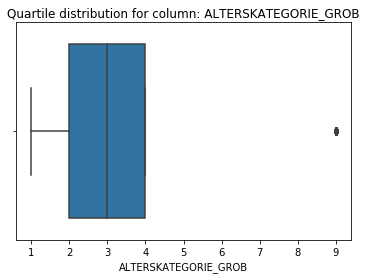

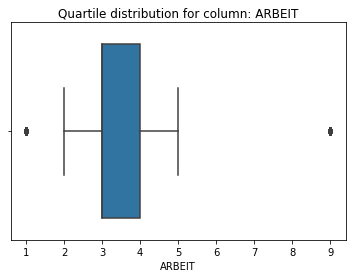

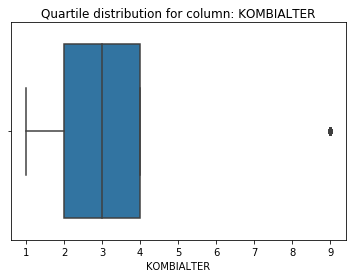

In [17]:
v_cols = v_valuesCount[ v_valuesCount['Value_count'] < 11 ].index.tolist()
for column in [ 'D19_GESAMT_DATUM_Value_INCREASE',
                'D19_GESAMT_ONLINE_DATUM_Value_ACTIVITY_WITHIN_MONTHS',
                'D19_GESAMT_ONLINE_DATUM_Value_INCREASE',
                'D19_VERSAND_DATUM_Value_INCREASE',
                'D19_VERSAND_ONLINE_DATUM_Value_ACTIVITY_WITHIN_MONTHS',
                'D19_VERSAND_OFFLINE_DATUM_Value_ACTIVITY_WITHIN_MONTHS',
                'D19_VERSAND_DATUM_Value_ACTIVITY_WITHIN_MONTHS',
                'D19_TELKO_DATUM_Value_ACTIVITY_WITHIN_MONTHS',
                'D19_VERSI_DATUM',
                'D19_GESAMT_ANZ_12', 
                'D19_VERSAND_ANZ_12',
                'D19_VERSICHERUNGEN',
                'WOHNDAUER_2008',
                'GEBAEUDETYP' ]:
    v_cols.remove(column)

print(f'Categorical like features: {v_cols}')
for column in v_cols:    
    sns.boxplot(x = v_azdias[column])
    plt.title(f'Quartile distribution for column: {column}')
    plt.show()

We will remap the following features:
   - ALTERSKATEGORIE_GROB - age through first name analysis
   - ARBEIT - share of unemployed person in the community
   - KOMBIALTER - unknown description
   
We will keep the following features as they are:
   - D19_GESAMT_ANZ_12  - transaction activity TOTAL POOL in the last 12 months
   - D19_VERSAND_ANZ_12 - transaction activity MAIL-ORDER in the last 12 months
   - D19_VERSICHERUNGEN - transactional activity based on the product group INSURANCES
   - GEBAEUDETYP        - type of building (residential or commercial)
   - WOHNDAUER_2008     - length of residence

In [18]:
g_outlierMap = { 'categorical': { 'ALTERSKATEGORIE_GROB': {9: 5},
                                  'ARBEIT':               {9: 5},
                                  'KOMBIALTER':           {9: 5} } } 
for column, mapValue in g_outlierMap['categorical'].items():
    v_azdias[column]    = v_azdias[column].replace(mapValue)
    v_customers[column] = v_customers[column].replace(mapValue)

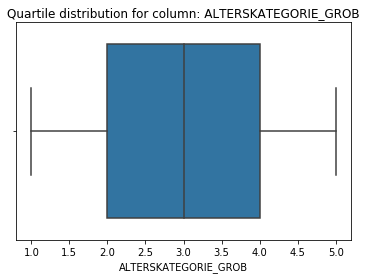

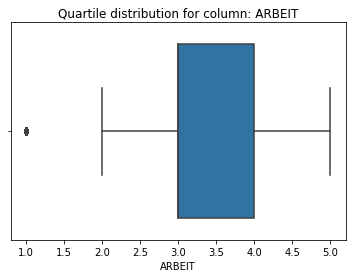

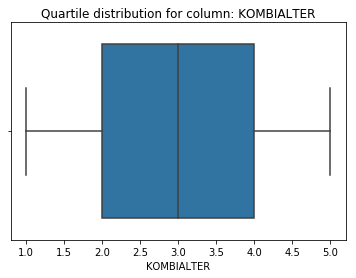

In [19]:
for column in g_outlierMap['categorical'].keys():    
    sns.boxplot(x = v_azdias[column])
    plt.title(f'Quartile distribution for column: {column}')
    plt.show()

---
We check also the features which are not categorical. We decide to ignore the features linked to EINGEFUEGT_AM.

Features not categorical like: ['ALTER_KIND3', 'ALTER_KIND4', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE', 'EINGEZOGENAM_HH_JAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR', 'VERDICHTUNGSRAUM']


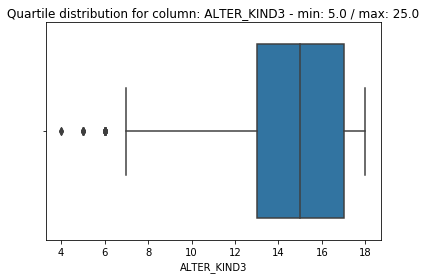

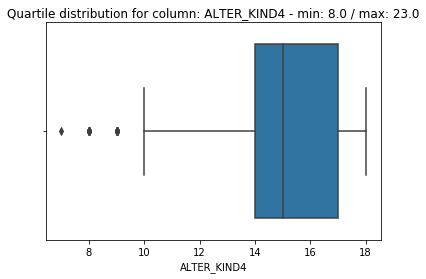

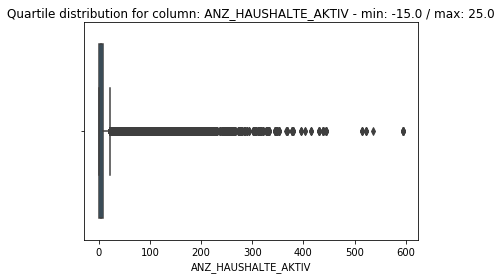

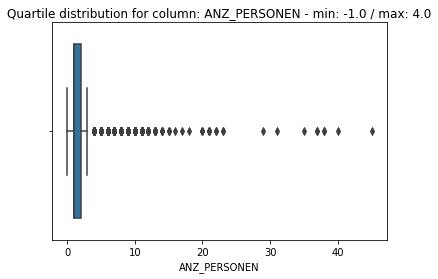

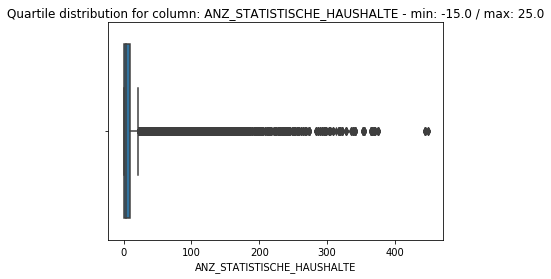

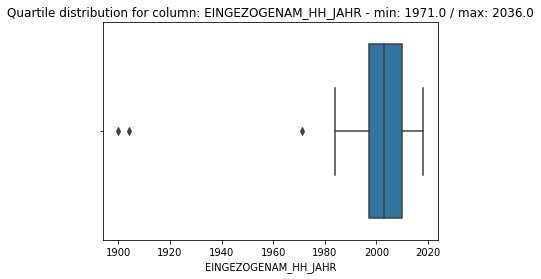

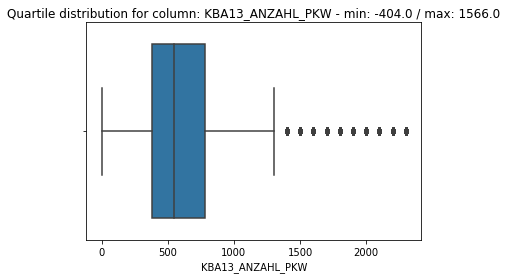

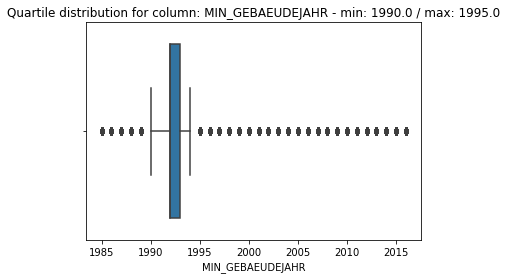

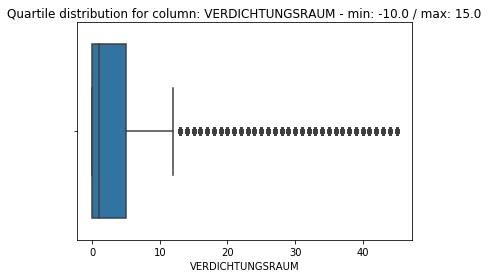

In [20]:
v_cols = v_valuesCount[ v_valuesCount['Value_count'] >= 11 ].index.tolist()
for column in ['EINGEFUEGT_AM_Day', 'EINGEFUEGT_AM_DayOfYear', 'EINGEFUEGT_AM_Year']:
    v_cols.remove(column)
print(f'Features not categorical like: {v_cols}')
for column in v_cols:    
    sns.boxplot(x = v_azdias[column])
    plt.title(f'Quartile distribution for column: {column} - min: {v_valuesCount.loc[column, "Q1"]} / max: {v_valuesCount.loc[column, "Q3"]}')
    plt.show()

For column ALTER_KIND3 and ALTER_KIND4 we will just keep the information linked to the fact that the column is filled-in or not.

In [21]:
for item in [ 'ALTER_KIND3', 'ALTER_KIND4' ]:
    v_azdias[item]    = v_azdias[item].fillna(-999).apply(lambda x: 0 if x == -999 else 1)
    v_customers[item] = v_customers[item].fillna(-999).apply(lambda x: 0 if x == -999 else 1)

For the columns which were identified as having outliers, and are not identified as being categorical, we do the following operations:
  - if the outliers are smaller than Q1, we create a new column that flags the value as being smaller than the minimum threshold and we set the column value as being the threshold
  - if the outliers are bigger than Q3, we create a new column that flags the value as being bigger than the maximum threshold and we set the column value as being the threshold

In [22]:
g_outlierMap['non_categorical_min'] = [ ('EINGEZOGENAM_HH_JAHR', 1978),
                                        ('MIN_GEBAEUDEJAHR', 1991) ]

g_outlierMap['non_categorical_max'] = [ ('ANZ_HAUSHALTE_AKTIV', 21),
                                        ('ANZ_PERSONEN', 4),
                                        ('ANZ_STATISTISCHE_HAUSHALTE', 25),
                                        ('KBA13_ANZAHL_PKW', 1566),
                                        ('MIN_GEBAEUDEJAHR', 1993),
                                        ('VERDICHTUNGSRAUM', 15) ]
    
for item in g_outlierMap['non_categorical_min']:
    v_azdias[f'_{item[0]}_MIN_{item[1]}']    = v_azdias[item[0]].fillna(item[1] + 1).apply(lambda x: 0 if x > item[1] else 1)
    v_customers[f'_{item[0]}_MIN_{item[1]}'] = v_customers[item[0]].fillna(item[1] + 1).apply(lambda x: 0 if x > item[1] else 1)
    v_azdias[item[0]]    = v_azdias[item[0]].fillna(item[1] + 1).apply(lambda x: x if x > item[1] else item[1])
    v_customers[item[0]] = v_customers[item[0]].fillna(item[1] + 1).apply(lambda x: x if x > item[1] else item[1])

for item in g_outlierMap['non_categorical_max']:
    v_azdias[f'_{item[0]}_MAX_{item[1]}']    = v_azdias[item[0]].fillna(item[1] - 1).apply(lambda x: 0 if x < item[1] else 1)
    v_customers[f'_{item[0]}_MAX_{item[1]}'] = v_customers[item[0]].fillna(item[1] - 1).apply(lambda x: 0 if x < item[1] else 1)
    v_azdias[item[0]]    = v_azdias[item[0]].fillna(item[1] - 1).apply(lambda x: x if x < item[1] else item[1])
    v_customers[item[0]] = v_customers[item[0]].fillna(item[1] - 1).apply(lambda x: x if x < item[1] else item[1])

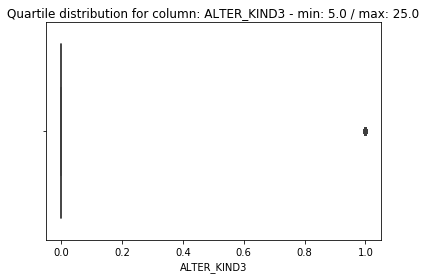

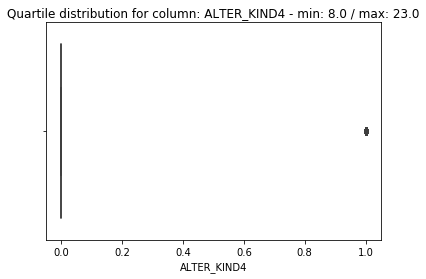

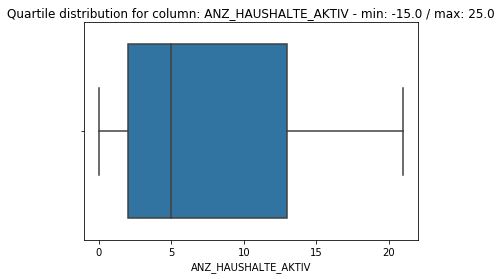

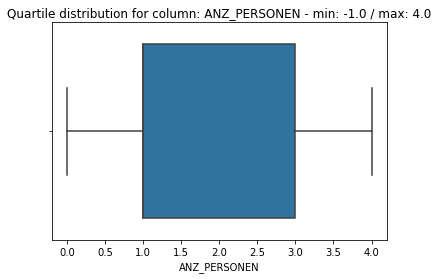

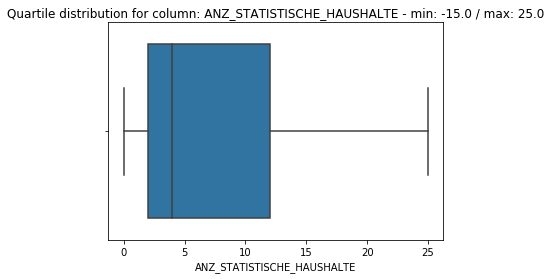

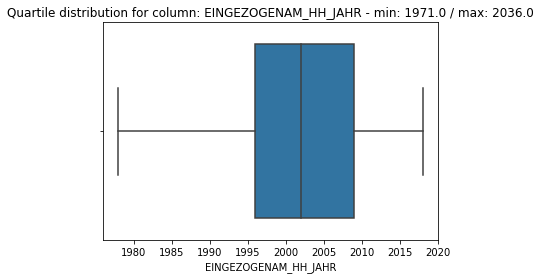

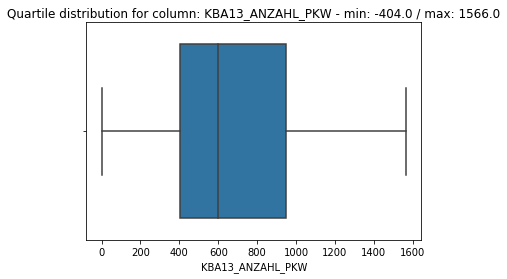

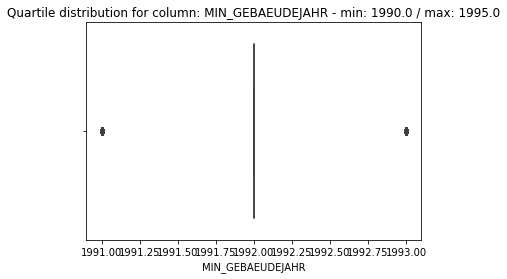

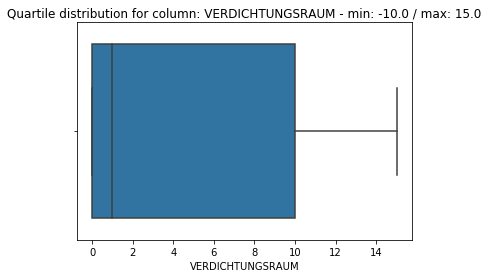

In [23]:
for column in v_cols:    
    sns.boxplot(x = v_azdias[column])
    plt.title(f'Quartile distribution for column: {column} - min: {v_valuesCount.loc[column, "Q1"]} / max: {v_valuesCount.loc[column, "Q3"]}')
    plt.show()

----
### Processing of categorical features

Identify categorical like columns.

In [24]:
g_valuesCount = utl_getValuesCount( p_azdias      = v_azdias, 
                                    p_customers   = v_customers,
                                    p_featuresDef = g_featuresDef )


********************************************************************************************


Extract all values from dataframes: **<span style="color: blue">Azdias</span>** and **<span style="color: blue">Customers</span>**.

100% (414 of 414) |######################| Elapsed Time: 0:00:13 Time:  0:00:13


In [25]:
g_categoricalColumns = []
for column in v_azdias.select_dtypes(exclude=['object']).drop(['LNR'], axis = 1).columns:
    v_values = g_valuesCount.loc[g_valuesCount[g_valuesCount['Column Name'] == column].index, 'Value'].fillna(-2).tolist()    
    if ( min(v_values) >= -2
         and max(v_values) <= 11
         and len(v_values) <= 12 ):
        g_categoricalColumns.append(column)

----
Check columns having type 'object' and do a processing using a custom mapping for the values. Show all the columns for which a mapping **is not** defined.

In [26]:
v_objectCols = v_azdias.select_dtypes(include=['object']).copy()  
for column in ['PRAEGENDE_JUGENDJAHRE_Value_0', 'GEMEINDETYP']:
    v_objectCols[column] = v_azdias[column]

g_categoricalToProcess = []
for column in v_objectCols.columns:    
    try:
        utl_processColumns(v_objectCols, column)
        g_categoricalToProcess.append(column)
    except Exception as err: 
        print('\n*******************************************************')
        print(f'Columns {column} could not be mapped:')    
        print(err)
        print(sorted(v_objectCols[column].astype(str).value_counts().index.tolist()))
        
g_categoricalToProcess = sorted(set(g_categoricalToProcess))
g_categoricalColumns.extend(g_categoricalToProcess)
g_categoricalColumns.append('ALTERSKATEGORIE_FEIN') # age through first name analysis
g_categoricalColumns.append('GFK_URLAUBERTYP')      # vacation habits
g_categoricalColumns = sorted(set(g_categoricalColumns))

print('\n*******************************************************')
print('Columns for which a mapping is defined:')   
display(g_categoricalToProcess)


*******************************************************
Columns CAMEO_DEU_2015 could not be mapped:
Unknown column name.
['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B', '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D', '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E', 'XX', 'nan']

*******************************************************
Columns D19_LETZTER_KAUF_BRANCHE could not be mapped:
Unknown column name.
['D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 

['CAMEO_DEUINTL_2015_Value_0',
 'CAMEO_DEUINTL_2015_Value_1',
 'GEMEINDETYP',
 'LP_FAMILIE_FEIN_Value_CHILD',
 'LP_FAMILIE_FEIN_Value_FAMILY',
 'LP_FAMILIE_FEIN_Value_GENERATIONAL',
 'LP_LEBENSPHASE_FEIN_Value_AGE',
 'LP_LEBENSPHASE_FEIN_Value_FAMILY',
 'LP_LEBENSPHASE_FEIN_Value_INCOME',
 'LP_LEBENSPHASE_FEIN_Value_OTHER',
 'LP_LEBENSPHASE_GROB_Value_AGE',
 'LP_LEBENSPHASE_GROB_Value_FAMILY',
 'LP_LEBENSPHASE_GROB_Value_INCOME',
 'LP_STATUS_FEIN_Value_INCOME',
 'LP_STATUS_FEIN_Value_OTHER',
 'OST_WEST_KZ',
 'PRAEGENDE_JUGENDJAHRE_Value_0',
 'PRAEGENDE_JUGENDJAHRE_Value_2',
 'PRAEGENDE_JUGENDJAHRE_Value_3']

----
### Processing of non-categorical features

Check the values for the columns not marked as categorical:

In [27]:
g_valuesCount = utl_getValuesCount( p_azdias      = v_azdias, 
                                    p_customers   = v_customers,
                                    p_featuresDef = g_featuresDef )

for column in v_azdias.select_dtypes(exclude=['object']).drop(['LNR'], axis = 1).columns:       
    if column not in g_categoricalColumns:
        v_values = g_valuesCount.loc[g_valuesCount[g_valuesCount['Column Name'] == column].index, 'Value'].fillna(-2).tolist() 
        print(column.ljust(30), str(len(v_values)).rjust(4), ' .... ', v_values[:9] + ['...'])


********************************************************************************************


Extract all values from dataframes: **<span style="color: blue">Azdias</span>** and **<span style="color: blue">Customers</span>**.

100% (414 of 414) |######################| Elapsed Time: 0:00:13 Time:  0:00:13


ALTER_HH                         23  ....  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, '...']
ALTER_KIND1                      18  ....  [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, '...']
ALTER_KIND2                      18  ....  [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, '...']
ANZ_HAUSHALTE_AKTIV              22  ....  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, '...']
ANZ_HH_TITEL                     22  ....  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, '...']
ANZ_STATISTISCHE_HAUSHALTE       26  ....  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, '...']
EINGEZOGENAM_HH_JAHR             36  ....  [1978.0, 1979.0, 1984.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, '...']
EXTSEL992                        57  ....  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, '...']
GEBURTSJAHR                     117  ....  [0, 1900, 1902, 1904, 1905, 1906, 1907, 1908, 1909, '...']
KBA13_ANZAHL_PKW               1255  ....  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, '...']
MIN_G

For column GEBURTSJAHR (year of birth) replace the value 0 with NaN.

In [28]:
v_azdias['GEBURTSJAHR']    = v_azdias['GEBURTSJAHR'].replace({0: np.NaN})
v_customers['GEBURTSJAHR'] = v_customers['GEBURTSJAHR'].replace({0: np.NaN})

For the features that contain a year value, do a transformation based on the decade.

In [29]:
v_lambda = lambda x: np.nan if x == -999 else (x - 1970) / 10
for column in [ 'EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR', 'MIN_GEBAEUDEJAHR', 'EINGEFUEGT_AM_Year' ]:
    v_azdias[column]   = v_azdias[column].fillna(-999).apply(v_lambda)
    v_customers[column] = v_customers[column].fillna(-999).apply(v_lambda)

We bin features KBA13_ANZAHL_PKW and EXTSEL992 by keeping only 30 bins.

In [30]:
g_mapValues = {}
for column in ['KBA13_ANZAHL_PKW', 'EXTSEL992']:
    v_map = g_valuesCount[g_valuesCount['Column Name'] == column][['Value']]
    v_map['mapped Value'] = pd.cut(v_map['Value'], bins = 30, labels = False)
    v_map.set_index('Value', inplace = True)
    g_mapValues = { column: v_map.to_dict()['mapped Value'] }    
    v_azdias[column]    = v_azdias[column].replace(g_mapValues[column])
    v_customers[column] = v_customers[column].replace(g_mapValues[column])

In [31]:
g_valuesCount = utl_getValuesCount( p_azdias      = v_azdias, 
                                    p_customers   = v_customers,
                                    p_featuresDef = g_featuresDef )

for column in v_azdias.select_dtypes(exclude=['object']).drop(['LNR'], axis = 1).columns:       
    if column not in g_categoricalColumns:
        v_values = g_valuesCount.loc[g_valuesCount[g_valuesCount['Column Name'] == column].index, 'Value'].fillna(-2).tolist() 
        print(column.ljust(30), str(len(v_values)).rjust(4), ' .... ', v_values[:9] + ['...'])


********************************************************************************************


Extract all values from dataframes: **<span style="color: blue">Azdias</span>** and **<span style="color: blue">Customers</span>**.

100% (414 of 414) |######################| Elapsed Time: 0:00:12 Time:  0:00:12


ALTER_HH                         23  ....  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, '...']
ALTER_KIND1                      18  ....  [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, '...']
ALTER_KIND2                      18  ....  [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, '...']
ANZ_HAUSHALTE_AKTIV              22  ....  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, '...']
ANZ_HH_TITEL                     22  ....  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, '...']
ANZ_STATISTISCHE_HAUSHALTE       26  ....  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, '...']
EINGEZOGENAM_HH_JAHR             36  ....  [0.8, 0.9, 1.4, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, '...']
EXTSEL992                        31  ....  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, '...']
GEBURTSJAHR                     117  ....  [-7.0, -6.8, -6.6, -6.5, -6.4, -6.3, -6.2, -6.1, -6.0, '...']
KBA13_ANZAHL_PKW                 28  ....  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, '...']
MIN_GEBAEUDEJAHR             

----
### Analysis of MISSING / UNKNOWN values

Calculate all the possible values and their distribution in both dataframes.

Missing values could follow a specific pattern, so we take into account that we can have the following situations:
   - data is **Missing Completely at Random (MCAR)** - no relationship between the missingness of the data and any values, observed or missing (nothing systematic going on)
   - data is **Missing at Random (MAR)** - we have a systematic relationship between the propensity of missing values and the observed data, but not the missing data. Whether an observation is missing has nothing to do with the missing values, but it does have to do with the values of an individual’s observed variables (eg: women are less-likely to tell their age or weight)
   - data is **Missing Not at Random (MNAR)** - there is a relationship between the propensity of a value to be missing and its values. This is a case where the people with the lowest education are missing on education.

------
We start by checking for a pattern for **MISSING** values.

In [32]:
v_null = ( g_valuesCount[g_valuesCount['Value'].isnull()]
                 .groupby(['Value %_Azdias', 'Value %_Cust'])
                 .agg({'Column Name': ['count']}) )
v_null.columns = ['Count']
display(v_null[v_null['Count'] != 1].sort_values('Count', ascending = False).head(10).reset_index())

,Value %_Azdias,Value %_Cust,Count
0,11.87,26.76,115
1,14.96,29.21,64
2,10.45,26.05,21
3,0.54,1.68,17
4,8.25,24.31,9
5,28.85,24.89,9
6,13.07,27.53,7
7,10.91,26.34,5
8,10.95,26.64,4
9,10.61,26.58,3


We can see that as there are multiple cases where we can see a clear correlation between the number of missing values for the different features, so we can consider that the values are **Missing Not at Random (MNAR)**.

------
We also check for a pattern for **UNKNOWN** values.

In [33]:
v_unknown = ( g_valuesCount[g_valuesCount['_isUnknown'] == 1]
                    .groupby(['Value %_Azdias', 'Value %_Cust'])
                    .agg({'Column Name': ['count']}) )
v_unknown.columns = ['Count']
display(v_unknown[v_unknown['Count'] != 1].sort_values('Count', ascending = False).head(10).reset_index())

,Value %_Azdias,Value %_Cust,Count
0,1.66,0.49,55
1,12.14,25.30,4
2,12.48,25.56,3
3,4.14,3.03,2


We can see that as there are multiple cases where we can see a clear correlation between the number of unknown values for the different features, so we can consider that the values are **Missing Not at Random (MNAR)**.

-----
As we know that we are in a MNAR situation, we will execute a **Principal component analysis (PCA)** on both **MISSING** and **UNKNOWN** data in order to identify the missing / unknown flags with a reduced dimensionality.

In [34]:
v_missingAzdias = v_azdias[['LNR']].copy()
v_missingCust   = v_customers[['LNR']].copy()

v_cols = v_azdias.columns.tolist()
with progressbar.ProgressBar(max_value = len(v_cols)) as bar:
    v_count = 0
    for column in v_cols:
        v_missingAzdias[column] = v_azdias[column].isnull().astype(int)
        v_missingCust[column]   = v_customers[column].isnull().astype(int)

        # In case we have only one value in both dataframes (which means that the column is always filled in) than we remove the
        # column as it will not bring any information.
        if ( v_missingAzdias[column].value_counts().shape[0] == 1
             and v_missingCust[column].value_counts().shape[0] == 1 ):
            v_missingAzdias.drop(column, axis = 1, inplace = True)
            v_missingCust.drop(column, axis = 1, inplace = True)
            
        v_count += 1
        bar.update(v_count)
v_missingAzdias.columns = [f'_isMissing_{item}' for item in v_missingAzdias.columns]
        
# Save the list of columns for which we will flag if values are missing or not        
g_colMissing = v_missingAzdias.columns.tolist()

100% (415 of 415) |######################| Elapsed Time: 0:02:10 Time:  0:02:10


In [35]:
v_unknownAzdias = v_azdias[['AGER_TYP']].copy()
v_unknownCust   = v_customers[['AGER_TYP']].copy()

g_colUnknownVals = {}
for column in g_valuesCount[g_valuesCount['_isUnknown'] == 1]['Column Name'].tolist():
    g_colUnknownVals[column] = g_valuesCount[   (g_valuesCount['_isUnknown'] == 1) 
                                              & (g_valuesCount['Column Name'] == column) ]['Value'].values[0]

v_cols = g_colUnknownVals.keys()
with progressbar.ProgressBar(max_value = len(v_cols)) as bar:
    v_count = 0
    for column in v_cols:
        v_value = g_colUnknownVals[column]
        v_unknownAzdias[column] = v_azdias[column].fillna(-999).apply(lambda x: 1 if x == v_value else 0 )
        v_unknownCust[column]   = v_customers[column].fillna(-999).apply(lambda x: 1 if x == v_value else 0 )

        # In case we have only one value in both dataframes (which means that the column is always known) than we remove the
        # column as it will not bring any information.
        if ( v_unknownAzdias[column].value_counts().shape[0] == 1
             and v_unknownCust[column].value_counts().shape[0] == 1 ):
            v_unknownAzdias.drop(column, axis = 1, inplace = True)
            v_unknownCust.drop(column, axis = 1, inplace = True)
            
        v_count += 1
        bar.update(v_count)       
v_unknownAzdias.columns = [f'_isUnknown_{item}' for item in v_unknownAzdias.columns]

100% (77 of 77) |########################| Elapsed Time: 0:00:29 Time:  0:00:29


---
Calculate the PCA for **MISSING** and **UNKNOWN** values and show the report for the weights.

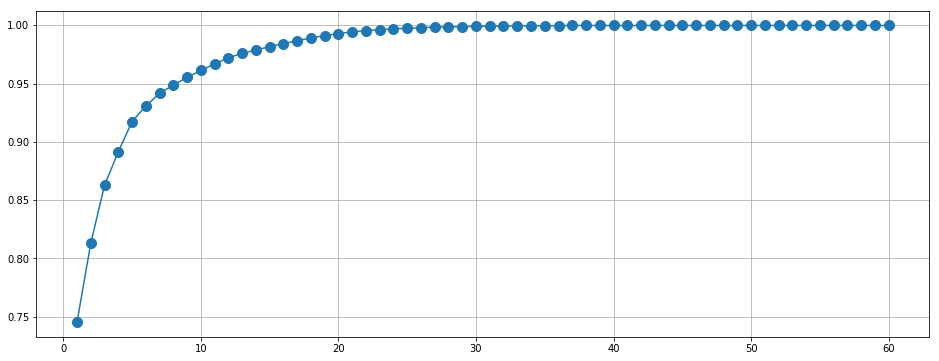

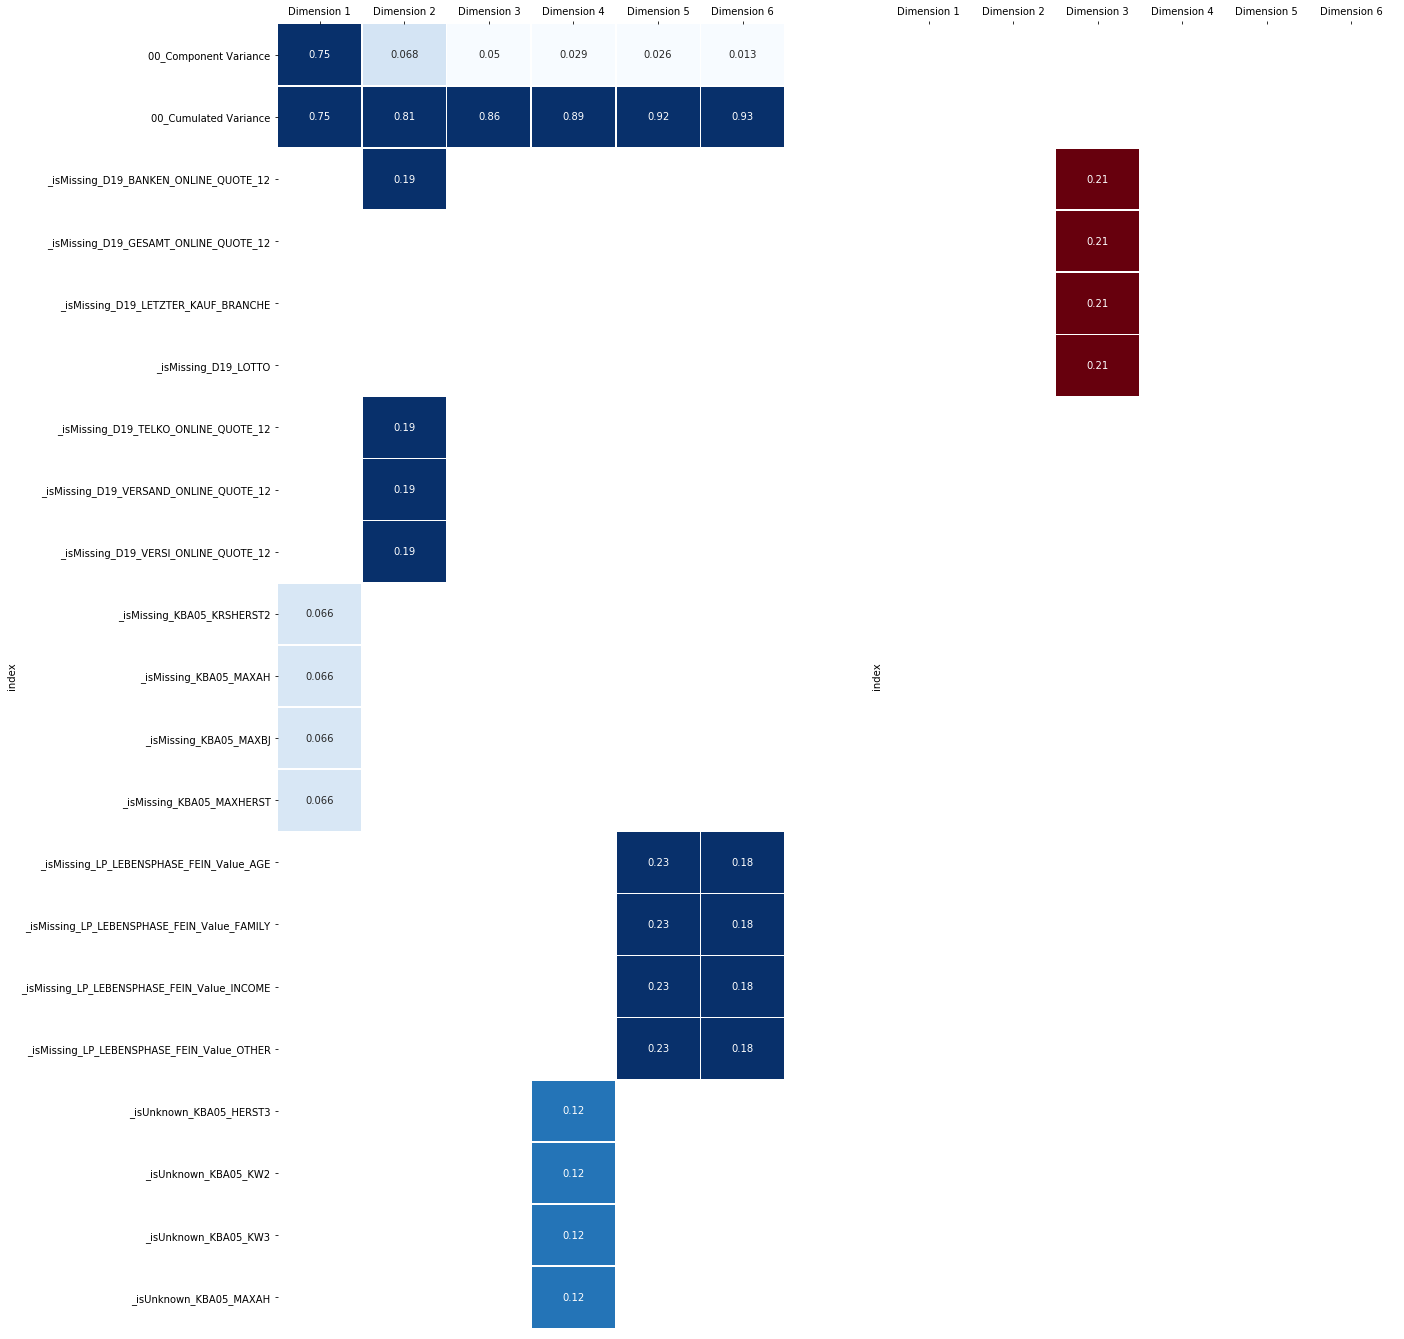

In [36]:
v_missingUnknownAzdias = pd.concat([v_missingAzdias, v_unknownAzdias], axis = 1)
g_pcaMissingUnknown = utl_applyPCA( p_data         = v_missingUnknownAzdias,
                                    p_n_components = 60,
                                    p_ShowWeights  = True,
                                    p_ShowTop      = 6,
                                    p_figHeight    = 24 )

Based of the visualisation above, we will select **18 dimensions** for the PCA, as they capture almost 100% of the total variance for unknown and missing values. 
We do a retrain for the PCA with the selected number of components, and save the trained PCA.

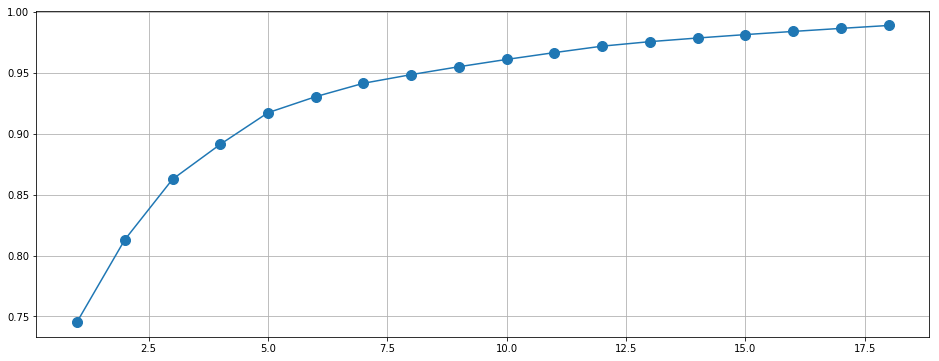

In [37]:
g_pcaMissingUnknown = utl_applyPCA( p_data         = v_missingUnknownAzdias,
                                    p_n_components = 18 )

-----------
### Fill-in missing values

We first re-encode some categorical columns.

In [38]:
for item in g_categoricalToProcess:
    utl_processColumns(v_azdias, item)
    utl_processColumns(v_customers, item)

---
Dummy encode the object columns not re-encoded above.

In [39]:
g_dummyEncode = {}
for column in v_azdias.select_dtypes(include=['object']).columns:
    v_azdias[column] = v_azdias[column].str.replace('/', '-').str.replace(' ', '_')
    v_dummy = pd.get_dummies(v_azdias[[column]])
    g_dummyEncode[column] = v_dummy.columns.tolist()

In [40]:
def replaceDummy(p_data, p_column, p_dummyEncode):
    if p_column not in p_data.columns: 
        for column in p_dummyEncode[p_column]:
            p_data[column] = 0
        return p_data
    
    p_data[p_column] = p_data[p_column].str.replace('/', '-').str.replace(' ', '_')
    p_data = pd.get_dummies(p_data, columns = [p_column])
    
    v_cols = [item for item in p_data.columns if (p_column in item and item not in p_dummyEncode[p_column])]
    if len(v_cols) > 0:
        p_data.drop(v_cols, axis = 1, inplace = True)
    
    for column in [item for item in p_dummyEncode[p_column] if item not in p_data.columns]:
        p_data[column] = 0
    
    return p_data
     
for column in list(g_dummyEncode.keys()):
    v_azdias    = replaceDummy( p_data        = v_azdias, 
                                p_column      = column, 
                                p_dummyEncode = g_dummyEncode )
    v_customers = replaceDummy( p_data        = v_customers, 
                                p_column      = column, 
                                p_dummyEncode = g_dummyEncode )

---
Fill in columns that are categorical with value -2.

In [41]:
with progressbar.ProgressBar(max_value = len(g_categoricalColumns)) as bar:
    v_count = 0
    for column in g_categoricalColumns:
        v_azdias[column]    = v_azdias[column].fillna(-2).astype(int)
        v_customers[column] = v_customers[column].fillna(-2).astype(int)
        v_count += 1
        bar.update(v_count)

100% (392 of 392) |######################| Elapsed Time: 0:00:15 Time:  0:00:15


---
Check the columns that still have empty values.

In [42]:
v_missingAzdias = pd.DataFrame({'Null Value': 0}, index = ['LNR'])
v_missingCust   = pd.DataFrame({'Null Value': 0}, index = ['LNR'])
for column in v_azdias.columns:
    v_missingAzdias.loc[column, 'Null Value'] = v_azdias[column].isnull().sum()
    v_missingCust.loc[column, 'Null Value']   = v_customers[column].isnull().sum()
v_missing = ( v_missingAzdias[v_missingAzdias['Null Value'] > 0]
                 .merge( v_missingCust[v_missingCust['Null Value'] > 0], 
                         how = 'outer', left_index = True, right_index = True,
                         suffixes = ('_Azdias', '_Cust') ) )
display(v_missing)

,Null Value_Azdias,Null Value_Cust
ALTER_HH,73499.0,46596.0
ALTER_KIND1,810163.0,179886.0
ALTER_KIND2,861722.0,186552.0
ANZ_HH_TITEL,97008.0,52110.0
EXTSEL992,654153.0,85283.0
GEBURTSJAHR,392318.0,93024.0
VK_DISTANZ,75917.0,47871.0
EINGEFUEGT_AM_Year,93148.0,49927.0
EINGEFUEGT_AM_Month,93148.0,49927.0
EINGEFUEGT_AM_Day,93148.0,49927.0


-------------
### Check for highly correlated features

We check the highly correlated features other than missing or unknown.

We only keep in the analysis the feature that have a correlation bigger than 0.95.

In [43]:
# Create correlation matrix
v_corr_matrix = v_azdias.replace({-1: np.NaN, -2: np.NaN}).drop('LNR', axis = 1).corr().abs()

# Select upper triangle of correlation matrix
v_upper = v_corr_matrix.where(np.triu(np.ones(v_corr_matrix.shape), k = 1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.85
v_toCheck = [column for column in v_upper.columns if any(v_upper[column] > 0.85)]

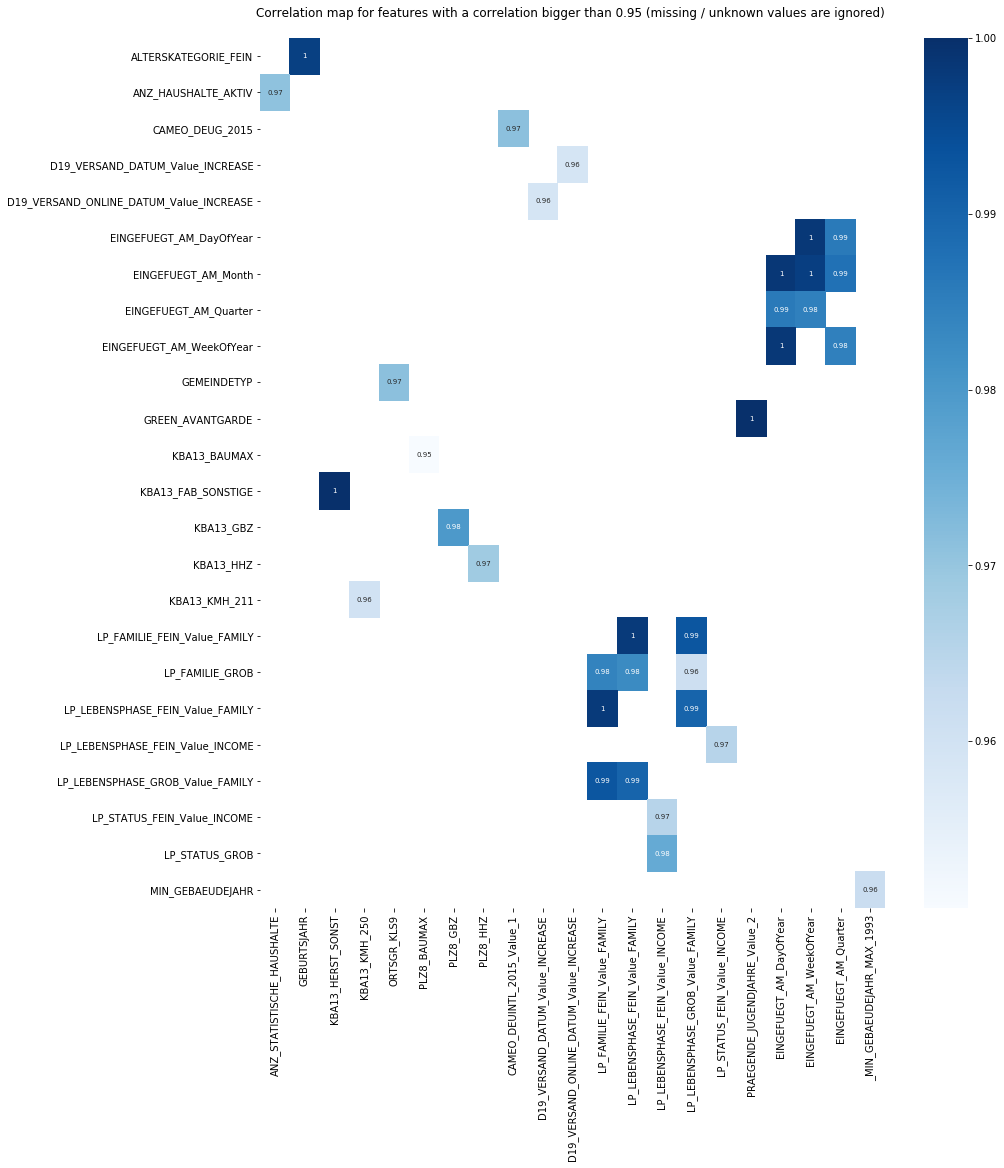

,ANZ_STATISTISCHE_HAUSHALTE,GEBURTSJAHR,KBA13_HERST_SONST,KBA13_KMH_250,ORTSGR_KLS9,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,CAMEO_DEUINTL_2015_Value_1,D19_VERSAND_DATUM_Value_INCREASE,...,LP_FAMILIE_FEIN_Value_FAMILY,LP_LEBENSPHASE_FEIN_Value_FAMILY,LP_LEBENSPHASE_FEIN_Value_INCOME,LP_LEBENSPHASE_GROB_Value_FAMILY,LP_STATUS_FEIN_Value_INCOME,PRAEGENDE_JUGENDJAHRE_Value_2,EINGEFUEGT_AM_DayOfYear,EINGEFUEGT_AM_WeekOfYear,EINGEFUEGT_AM_Quarter,_MIN_GEBAEUDEJAHR_MAX_1993
ALTERSKATEGORIE_FEIN,NaN,0.99705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANZ_HAUSHALTE_AKTIV,0.970999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CAMEO_DEUG_2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.971238,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D19_VERSAND_DATUM_Value_INCREASE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D19_VERSAND_ONLINE_DATUM_Value_INCREASE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.959064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EINGEFUEGT_AM_DayOfYear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998356,0.986035,NaN
EINGEFUEGT_AM_Month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.998479,0.997116,0.987608,NaN
EINGEFUEGT_AM_Quarter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.986035,0.984832,NaN,NaN
EINGEFUEGT_AM_WeekOfYear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.998356,NaN,0.984832,NaN
GEMEINDETYP,NaN,NaN,NaN,NaN,0.971316,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
v_data = pd.DataFrame()
for column in v_toCheck:
    v_value = v_corr_matrix.drop(column, axis = 1).loc[column, :]
    v_value = v_value[v_value > 0.95]
    if v_value.shape[0] > 0: 
        v_data = v_data.merge(pd.DataFrame(v_value), how = 'outer', left_index = True, right_index = True)

fig, ax = plt.subplots(figsize=(14, 16)) 
sns.heatmap(v_data, annot=True, annot_kws={"size": 7}, ax = ax, cmap="Blues")
plt.title('Correlation map for features with a correlation bigger than 0.95 (missing / unknown values are ignored) \n')
plt.show()

display(v_data)

In [45]:
g_highlyCorrelated = [ 'ANZ_STATISTISCHE_HAUSHALTE', 'EINGEFUEGT_AM_DayOfYear', 'EINGEFUEGT_AM_Minute',
                       'EINGEFUEGT_AM_Second', 'EINGEFUEGT_AM_Hour', 'EINGEFUEGT_AM_Quarter', 'EINGEFUEGT_AM_WeekOfYear', 
                       'GEBURTSJAHR', 'KBA13_HERST_SONST', 'KBA13_KMH_250', 'ORTSGR_KLS9', 'PLZ8_BAUMAX', 'PLZ8_GBZ',
                       'PLZ8_HHZ', 'CAMEO_DEUINTL_2015_Value_1', 'LP_LEBENSPHASE_FEIN_Value_FAMILY', 
                       'LP_LEBENSPHASE_FEIN_Value_INCOME', 'LP_LEBENSPHASE_GROB_Value_FAMILY', 'LP_FAMILIE_GROB',
                       'PRAEGENDE_JUGENDJAHRE_Value_2', '_MIN_GEBAEUDEJAHR_MAX_1993', 
                       'D19_VERSAND_ONLINE_DATUM_Value_INCREASE' ]

In [46]:
v_azdias.drop(g_highlyCorrelated, axis = 1, inplace = True)

--------
### Save all global variables / models for further use.

In [47]:
joblib.dump(g_pcaMissingUnknown, g_saveFilenames['pcaMissingUnknown'])

with open(g_saveFilenames['featuresDef'], 'w') as outfile:
    json.dump(g_featuresDef, outfile)
    
with open(g_saveFilenames['categoricalColumns'], 'w') as outfile:
    json.dump(g_categoricalColumns, outfile)
    
with open(g_saveFilenames['categoricalToProcess'], 'w') as outfile:
    json.dump(g_categoricalToProcess, outfile)
    
with open(g_saveFilenames['dummyEncode'], 'w') as outfile:
    json.dump(g_dummyEncode, outfile)
    
with open(g_saveFilenames['highlyCorrelated'], 'w') as outfile:
    json.dump(g_highlyCorrelated, outfile)
    
with open(g_saveFilenames['colMissing'], 'w') as outfile:
    json.dump(g_colMissing, outfile)
    
with open(g_saveFilenames['colUnknownVals'], 'w') as outfile:
    json.dump(g_colUnknownVals, outfile)
    
with open(g_saveFilenames['mapValues'], 'w') as outfile:
    json.dump(g_mapValues, outfile)
    
with open(g_saveFilenames['outliers'], 'w') as outfile:
    json.dump(g_outlierMap, outfile)
    
with open(g_saveFilenames['ignoreScale'], 'w') as outfile:
    json.dump(['LNR'], outfile)

-----------
-------------
----------

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

------
### Clean both datasets

Based on finding above, we will create a cleaning procedure that we will apply on all future datasets having the same format.

For the cleaning of datasets, we will execute the following operations:
   1. **clean data based on the definition** - only one possible value will be kept when there were multiple values specififed for the same row in the definitions
   2. re-encode categorical features
   3. apply the Principal Component Analysis for the **missing values**, by using the trained PCA from above
   4. apply the Principal Component Analysis for the **unknow values**, by using the trained PCA from above
   5. fill in categorical columns with -2
   6. drop features identified as highly correlated
   7. calculate columns to be imputed later
   8. calculate columns to be scaled later

In [48]:
v_azdias, v_missing, v_scaleColumns = utl_cleanDataFrame( p_label         = 'Azdias', 
                                                          p_data          = azdias,
                                                          p_saveFilenames = g_saveFilenames )    
v_customers, _, _ = utl_cleanDataFrame( p_label         = 'Customers', 
                                        p_data          = customers,
                                        p_saveFilenames = g_saveFilenames )


********************************************************************************************


START Clean dataframe **<span style="color: blue">Azdias</span>**.

Clean dataframe **<span style="color: blue">Azdias</span>** based on definition.

Re-encode columns values based on definition.

100% (314 of 314) |######################| Elapsed Time: 0:06:57 Time:  0:06:57


Transform object columns to numeric.

100% (23 of 23) |########################| Elapsed Time: 0:00:06 Time:  0:00:06



********************************************************************************************


Reduce memory usage for dataframe **<span style="color: blue">Azdias</span>**.

Initial memory usage is 849.93 MBs.


  1% (5 of 390) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 0 to 891220
Columns: 390 entries, LNR to PRAEGENDE_JUGENDJAHRE_Value_3
dtypes: float16(283), int64(24), int8(4), object(21), uint16(1), uint32(1), uint8(56)
memory usage: 849.9+ MB
None


100% (390 of 390) |######################| Elapsed Time: 0:00:11 Time:  0:00:11



Final memory usage is 691.0 MBs.
This is 81.3% of the initial size.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 0 to 891220
Columns: 390 entries, LNR to PRAEGENDE_JUGENDJAHRE_Value_3
dtypes: float16(264), int8(6), object(21), uint16(1), uint32(1), uint8(97)
memory usage: 691.0+ MB
None


Re-encode column **<span style="color: blue">EINGEFUEGT_AM</span>**.

Re-encode outliers.

Re-encode column having year format **<span style="color: blue">EINGEZOGENAM_HH_JAHR</span>**.

Re-encode column having year format **<span style="color: blue">GEBURTSJAHR</span>**.

Re-encode column having year format **<span style="color: blue">MIN_GEBAEUDEJAHR</span>**.

Re-encode column having year format **<span style="color: blue">EINGEFUEGT_AM_Year</span>**.

Apply mapping for column: **<span style="color: blue">EXTSEL992</span>**.

Calculate the reduced dimension flags for **<span style="color: blue">MISSING</span>** and **<span style="color: blue">UNKNOWN</span>** values.

Concatenate the calculated missing / unknonw with reduced dimension.

Re-encode some categorical columns.

Dummy encode the object columns not re-encoded above.

Fill in categorical columns with -2.

Drop features identified as highly correlated.

Calculate columns to be imputed later.

Calculate columns to be scaled later.


********************************************************************************************


END Clean dataframe **<span style="color: blue">Azdias</span>**.


********************************************************************************************


START Clean dataframe **<span style="color: blue">Customers</span>**.

Clean dataframe **<span style="color: blue">Customers</span>** based on definition.

Re-encode columns values based on definition.

100% (314 of 314) |######################| Elapsed Time: 0:01:30 Time:  0:01:30


Transform object columns to numeric.

100% (25 of 25) |########################| Elapsed Time: 0:00:01 Time:  0:00:01



********************************************************************************************


Reduce memory usage for dataframe **<span style="color: blue">Customers</span>**.

  5% (20 of 393) |#                      | Elapsed Time: 0:00:00 ETA:  00:00:00

Initial memory usage is 185.88 MBs.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 0 to 191651
Columns: 393 entries, LNR to PRAEGENDE_JUGENDJAHRE_Value_3
dtypes: float16(283), int64(24), int8(4), object(23), uint16(1), uint32(1), uint8(57)
memory usage: 185.9+ MB
None


100% (393 of 393) |######################| Elapsed Time: 0:00:02 Time:  0:00:02



Final memory usage is 151.7 MBs.
This is 81.61% of the initial size.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 0 to 191651
Columns: 393 entries, LNR to PRAEGENDE_JUGENDJAHRE_Value_3
dtypes: float16(264), int8(6), object(23), uint16(1), uint32(1), uint8(98)
memory usage: 151.7+ MB
None


Re-encode column **<span style="color: blue">EINGEFUEGT_AM</span>**.

Re-encode outliers.

Re-encode column having year format **<span style="color: blue">EINGEZOGENAM_HH_JAHR</span>**.

Re-encode column having year format **<span style="color: blue">GEBURTSJAHR</span>**.

Re-encode column having year format **<span style="color: blue">MIN_GEBAEUDEJAHR</span>**.

Re-encode column having year format **<span style="color: blue">EINGEFUEGT_AM_Year</span>**.

Apply mapping for column: **<span style="color: blue">EXTSEL992</span>**.

Calculate the reduced dimension flags for **<span style="color: blue">MISSING</span>** and **<span style="color: blue">UNKNOWN</span>** values.

Concatenate the calculated missing / unknonw with reduced dimension.

Re-encode some categorical columns.

Dummy encode the object columns not re-encoded above.

Fill in categorical columns with -2.

Drop features identified as highly correlated.

Calculate columns to be imputed later.

Calculate columns to be scaled later.


********************************************************************************************


END Clean dataframe **<span style="color: blue">Customers</span>**.

Check the number of records in both datasets and display the columns which are missing in one of the two datasets.

In [49]:
print(f'Number of records / features in the general population dataset: {v_azdias.shape}')
print(f'Number of records / features in the customers dataset:          {v_customers.shape}')
print('')
print('Columns only available in the general population dataset:', [item for item in v_azdias.columns if item not in v_customers.columns])
print('Columns only available in the customers dataset:',          [item for item in v_customers.columns if item not in v_azdias.columns])

Number of records / features in the general population dataset: (891221, 501)
Number of records / features in the customers dataset:          (191652, 504)

Columns only available in the general population dataset: []
Columns only available in the customers dataset: ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


### Apply PCA on general population

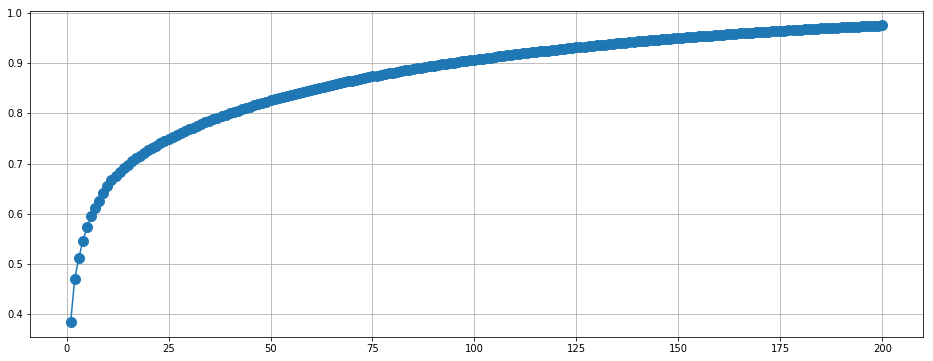

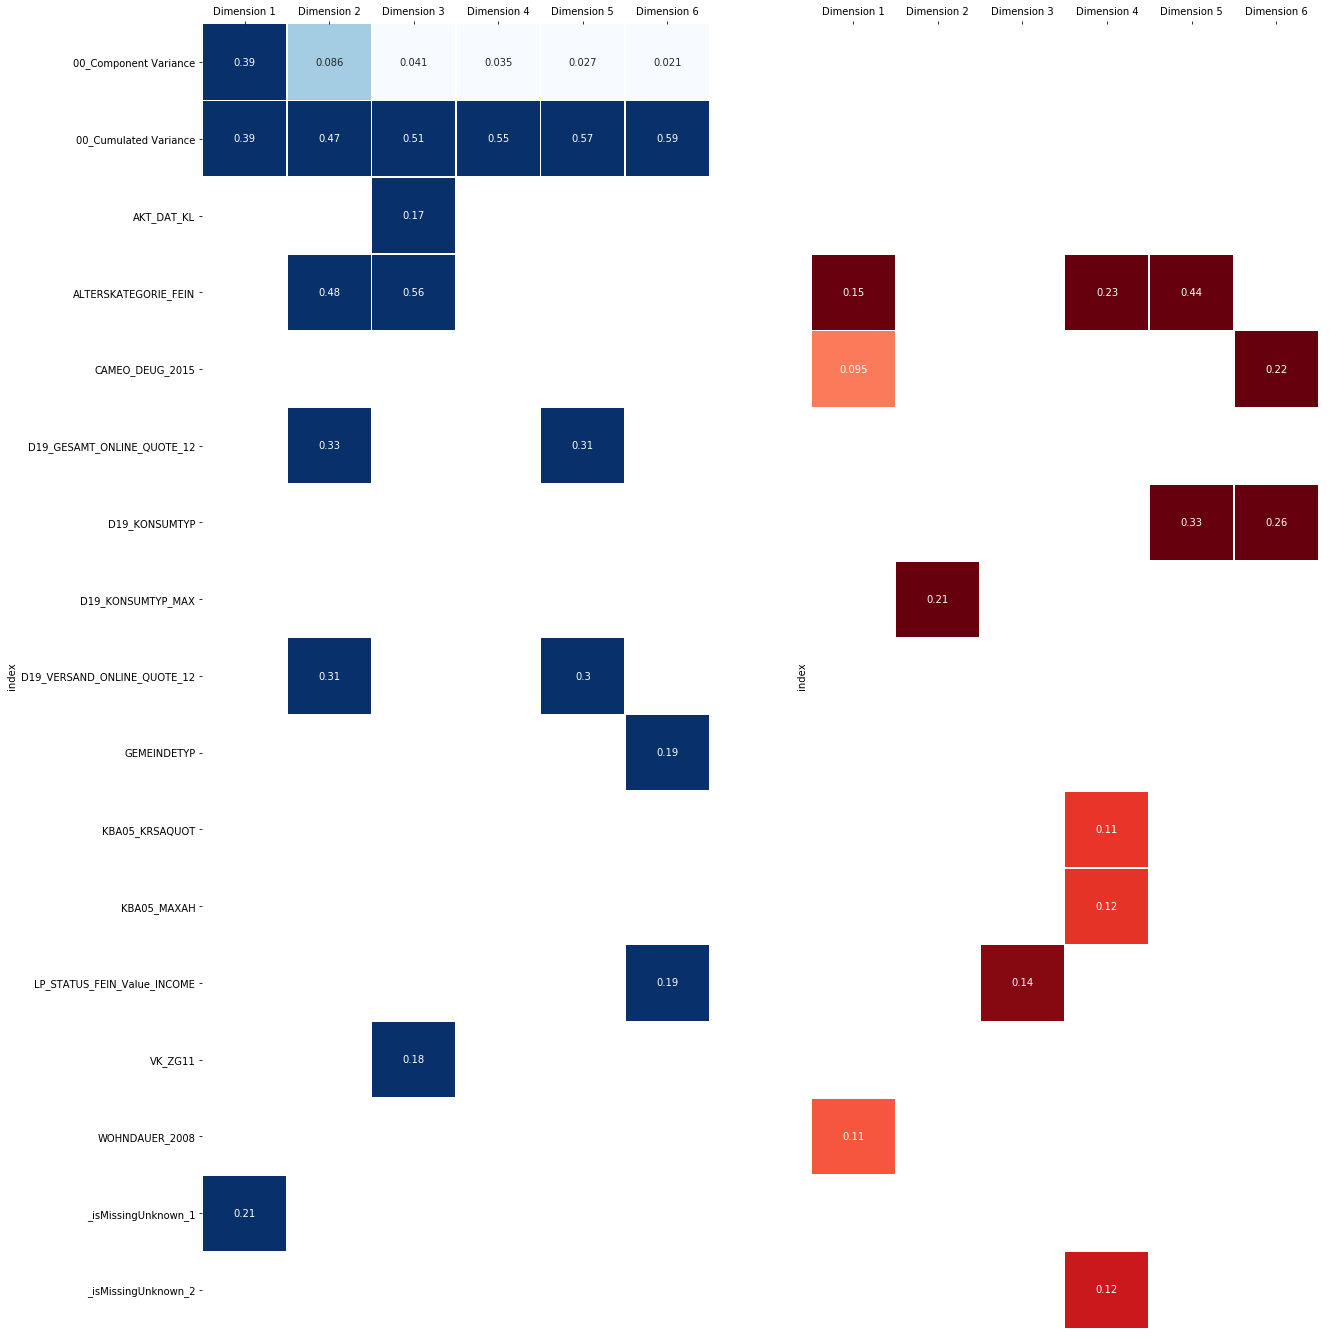

In [50]:
X_azdias, v_scalers = utl_scaleImpute( X_data          = v_azdias.drop(['LNR'], axis = 1), 
                                       p_imputeColumns = v_missing, 
                                       p_scaleColumns  = v_scaleColumns,
                                       p_scalers       = None )

X_customers, _      = utl_scaleImpute( X_data          = v_customers.drop([ 'LNR',
                                                                            'PRODUCT_GROUP', 
                                                                            'CUSTOMER_GROUP', 
                                                                            'ONLINE_PURCHASE' ], axis = 1), 
                                       p_imputeColumns = v_missing, 
                                       p_scaleColumns  = v_scaleColumns,
                                       p_scalers       = v_scalers )

g_pcaAzdias = utl_applyPCA( p_data         = X_azdias,
                            p_n_components = 200,
                            p_ShowWeights  = True,
                            p_ShowTop      = 6,
                            p_figHeight    = 24 )

We can see that **100 dimension** capture **90%** of the variance, so we refit the pca with 100 components.

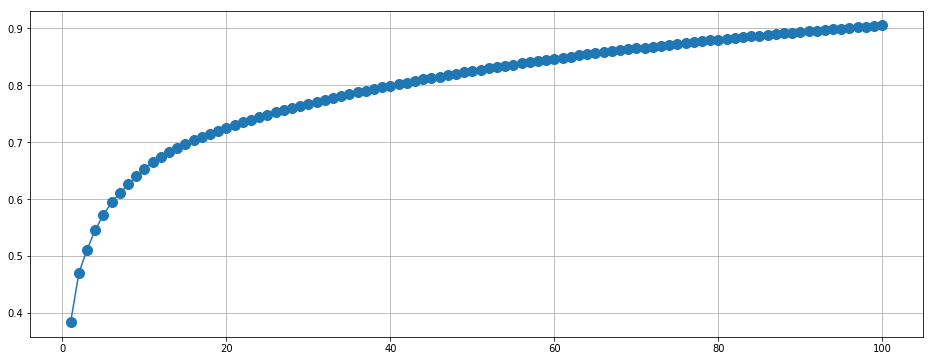

In [51]:
g_pcaAzdias = utl_applyPCA( p_data         = X_azdias,
                            p_n_components = 100 )

We transform both datasets, so that we can than execute the clustering.

In [52]:
X_pca_azdias    = g_pcaAzdias.transform(X_azdias)
X_pca_customers = g_pcaAzdias.transform(X_customers)

--------
### Fit clusters using Gaussian mixture

In order to correct the overfitting, we adjust the model likelihoods using some analytic criterion such as the Akaike information criterion (AIC) or the Bayesian information criterion (BIC).

In [53]:
try:
    v_dataGMM_Tied = pd.read_csv('models/clusters/BIC_GMM_Tied.csv', sep = ';')
except:
    v_dataGMM_Tied = pd.DataFrame()
    for clusterNo in range(2, 30, 2):
        v_model = GaussianMixture( clusterNo, 
                                   covariance_type = 'tied', 
                                   random_state    = 2013, 
                                   warm_start      = True,
                                   max_iter        = 60 ).fit(X_pca_azdias)
        v_dataGMM_Tied.loc[clusterNo, 'Clusters'] = clusterNo
        v_dataGMM_Tied.loc[clusterNo, 'BIC']      = v_model.bic(X_pca_azdias)
        v_dataGMM_Tied.loc[clusterNo, 'AIC']      = v_model.aic(X_pca_azdias)
    v_dataGMM_Tied.to_csv('models/clusters/BIC_GMM_Tied.csv', sep = ';', index = False)

In [54]:
try:
    v_dataGMM_Full = pd.read_csv('models/clusters/BIC_GMM_Full.csv', sep = ';')
except:
    v_dataGMM_Full = pd.DataFrame()
    for clusterNo in range(2, 30, 2):
        v_model = GaussianMixture( clusterNo, 
                                   covariance_type = 'full', 
                                   random_state    = 2013, 
                                   warm_start      = True,
                                   verbose         = 1,
                                   max_iter        = 60 ).fit(X_pca_azdias)
        v_dataGMM_Full.loc[clusterNo, 'Clusters'] = clusterNo
        v_dataGMM_Full.loc[clusterNo, 'BIC']      = v_model.bic(X_pca_azdias)
        v_dataGMM_Full.loc[clusterNo, 'AIC']      = v_model.aic(X_pca_azdias)
    v_dataGMM_Full.to_csv('models/clusters/BIC_GMM_Full.csv', sep = ';', index = False)

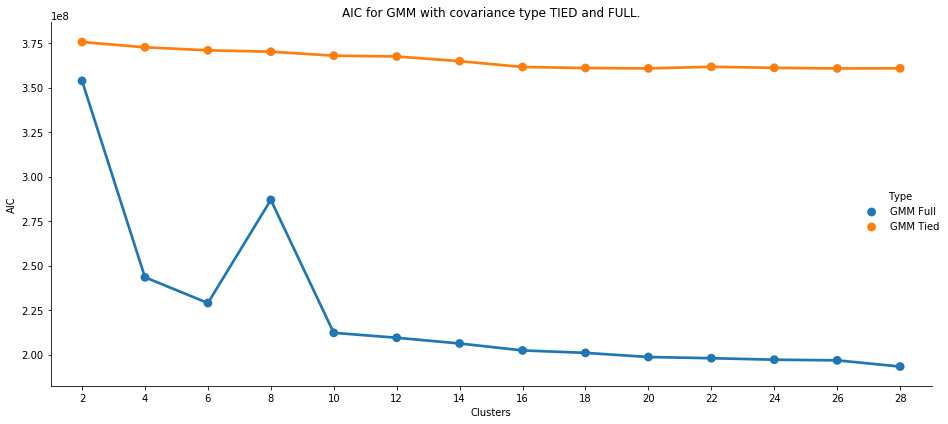

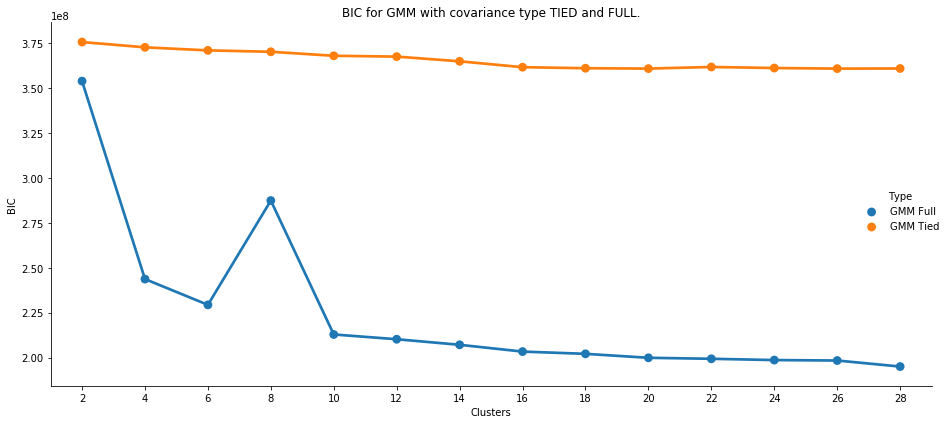

In [55]:
v_dataGMM_Full['Type'] = 'GMM Full'
v_dataGMM_Tied['Type'] = 'GMM Tied'

for item in ['AIC', 'BIC']:
    v_data = pd.concat([ v_dataGMM_Full, v_dataGMM_Tied ])
    v_data[[item, 'Clusters']] = v_data[[item, 'Clusters']].astype(int)
    g = sns.catplot(x = "Clusters", y = item, hue = 'Type', kind = "point", data = v_data, height = 6, aspect = 2)
    plt.title(f'{item} for GMM with covariance type TIED and FULL.')
    plt.tight_layout() 
    plt.show()

--------
### Fit clusters using KMeans

We can see from the above visualisation that both AIC and BIC find a local minimum for 6 clusters, but that this is not the global optimum.

We will also fit KMeans clusters and compare them to the GMM with the FULL covariance type.

For KMeans we will also recalculate the PCA with 150 components in order to see the change for the BIC.

In [56]:
def computeBIC(p_kmeans, X_data):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    p_kmeanModel:  List of clustering object from scikit learn

    X_data      :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    v_centers = [p_kmeans.cluster_centers_]
    v_labels  = p_kmeans.labels_
    #number of clusters
    m = p_kmeans.n_clusters
    # size of the clusters
    n = np.bincount(v_labels)
    #size of data set
    N, d = X_data.shape
    
    #compute variance for all clusters beforehand
    v_clusterVar = ( 1.0 / (N - m) / d ) \
                     * sum( [ sum(cdist(X_data[np.where(v_labels == i)], [v_centers[0][i]], 'euclidean')**2) 
                                 for i in range(m) ])
    
    v_constTerm = 0.5 * m * np.log(N) * (d + 1)
    BIC = np.sum([   n[i] * np.log(n[i]) 
                   - n[i] * np.log(N) 
                   - ( (n[i] * d) / 2) * np.log(2 * np.pi * v_clusterVar) 
                   - ( (n[i] - 1) * d / 2) for i in range(m) ]) - v_constTerm

    return -(BIC)

def fitClusters(X_data, p_from, p_to, p_random_state = 2013):
    kMeansVar = {}
    for key in range(p_from, p_to):
        kMeansVar[key] = KMeans( random_state = p_random_state,
                                 n_clusters = key, 
                                 precompute_distances = True,
                                 n_jobs = -1,
                                 n_init = 15,
                                 tol = 1e-3 ).fit(X_data)
        print(f'For {key} cluster(s) the sum of distances to the cluster center is {round(kMeansVar[key].inertia_, 2)}.')        
    
    v_dataKMean = pd.DataFrame()
    for clusterNo in list(kMeansVar.keys()):
        v_dataKMean.loc[clusterNo, 'Clusters'] = clusterNo
        v_dataKMean.loc[clusterNo, 'BIC']      = computeBIC( kMeansVar[clusterNo], X_pca_azdias )
        
    return kMeansVar, v_dataKMean

In [57]:
try:
    v_kmeans_100    = joblib.load('models/clusters/Kmeans_100.sav')
    v_dataKMean_100 = pd.read_csv('models/clusters/BIC_Kmeans_100.csv', sep = ';') 
except:
    v_pcaAzdias = utl_applyPCA( p_data         = X_azdias,
                                p_n_components = 100 )
    X_pca_azdias    = v_pcaAzdias.transform(X_azdias)
    v_kmeans_100, v_dataKMean_100 = fitClusters(X_pca_azdias, 1, 18)   
    v_dataKMean_100['Type']       = 'KMean 100 dimensions'
    joblib.dump(v_kmeans_100, 'models/clusters/Kmeans_100.sav')
    v_dataKMean_100.to_csv('models/clusters/BIC_Kmeans_100.csv', sep = ';', index = False)
    X_pca_azdias = g_pcaAzdias.transform(X_azdias)

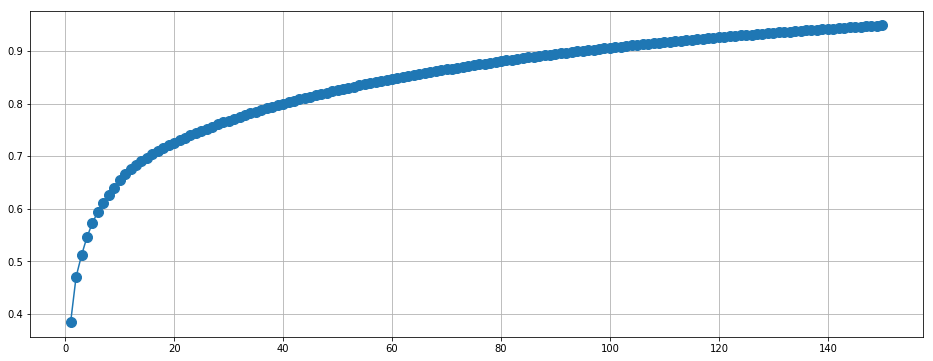

For 1 cluster(s) the sum of distances to the cluster center is 1158880875.52.
For 2 cluster(s) the sum of distances to the cluster center is 712810319.97.
For 3 cluster(s) the sum of distances to the cluster center is 640524851.98.
For 4 cluster(s) the sum of distances to the cluster center is 596365445.8.
For 5 cluster(s) the sum of distances to the cluster center is 563025662.8.
For 6 cluster(s) the sum of distances to the cluster center is 541824525.59.
For 7 cluster(s) the sum of distances to the cluster center is 523012122.99.
For 8 cluster(s) the sum of distances to the cluster center is 513699452.59.
For 9 cluster(s) the sum of distances to the cluster center is 504562857.92.
For 10 cluster(s) the sum of distances to the cluster center is 497869707.64.
For 11 cluster(s) the sum of distances to the cluster center is 489801124.73.
For 12 cluster(s) the sum of distances to the cluster center is 484368815.77.
For 13 cluster(s) the sum of distances to the cluster center is 477281828.

In [58]:
try:
    v_kmeans_150    = joblib.load('models/clusters/Kmeans_150.sav')
    v_dataKMean_150 = pd.read_csv('models/clusters/BIC_Kmeans_150.csv', sep = ';') 
except:
    v_pcaAzdias = utl_applyPCA( p_data         = X_azdias,
                                p_n_components = 150 )
    X_pca_azdias    = v_pcaAzdias.transform(X_azdias)
    v_kmeans_150, v_dataKMean_150 = fitClusters(X_pca_azdias, 1, 18)   
    v_dataKMean_150['Type']       = 'KMean 150 dimensions'
    joblib.dump(v_kmeans_150, 'models/clusters/Kmeans_150.sav')
    v_dataKMean_150.to_csv('models/clusters/BIC_Kmeans_150.csv', sep = ';', index = False)
    X_pca_azdias = g_pcaAzdias.transform(X_azdias)

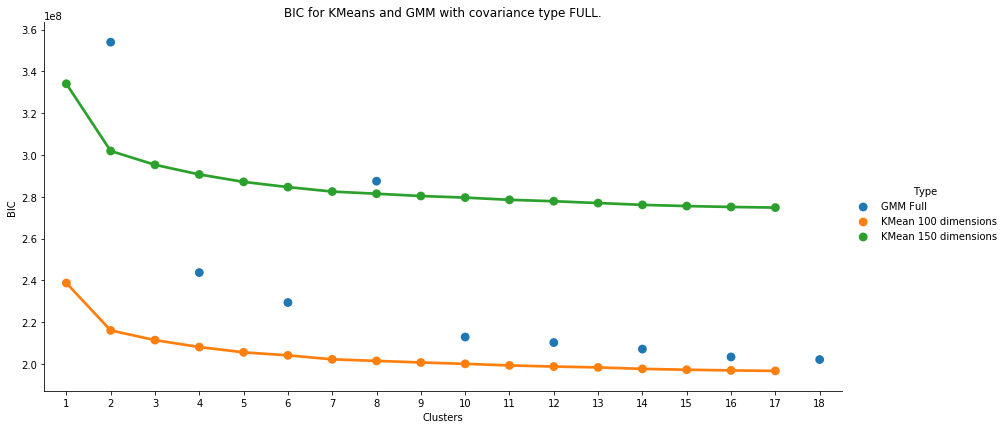

In [106]:
v_data = pd.concat([ v_dataGMM_Full[v_dataGMM_Full['Clusters'] < 19].drop('AIC', axis = 1), 
                     v_dataKMean_100,
                     v_dataKMean_150 ])
v_data[['BIC', 'Clusters']] = v_data[['BIC', 'Clusters']].astype(int)
g = sns.catplot(x = "Clusters", y = 'BIC', hue = 'Type', kind = "point", data = v_data, height = 6, aspect = 2)
plt.title(f'BIC for KMeans and GMM with covariance type FULL.') 
plt.show()

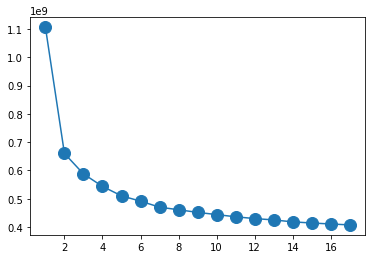

In [60]:
plt.plot( v_kmeans_100.keys(), 
          [v_kmeans_100[key].inertia_ for key in v_kmeans_100.keys()], 
          marker = 'o', markersize = 12 )
plt.show()

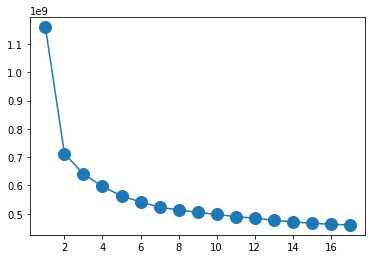

In [63]:
plt.plot( v_kmeans_150.keys(), 
          [v_kmeans_150[key].inertia_ for key in v_kmeans_150.keys()], 
          marker = 'o', markersize = 12 )
plt.show()

---
Based on the results above, we see that the best model based on the BIC in the KMean with 100 dimensions.

We check the distribution of the clusters for general population and for the customers.

We choose to check the models with 3, 4 and 5 clusters.



************************************************************************************
Calculate distributions for a KMean model with 3 clusters


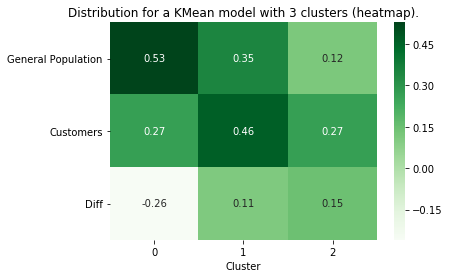

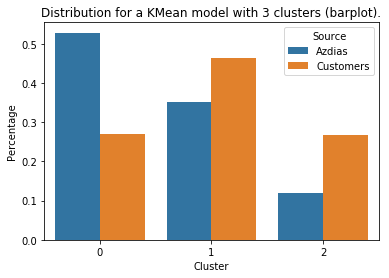

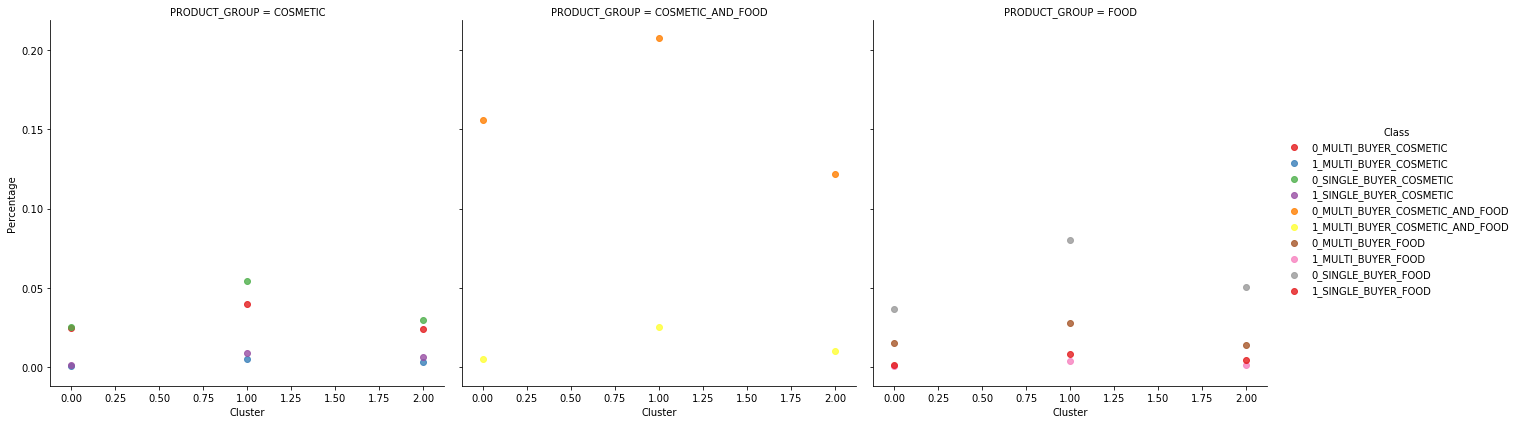

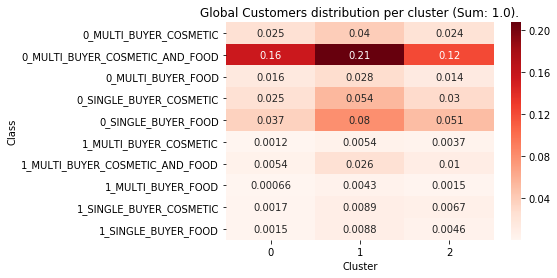

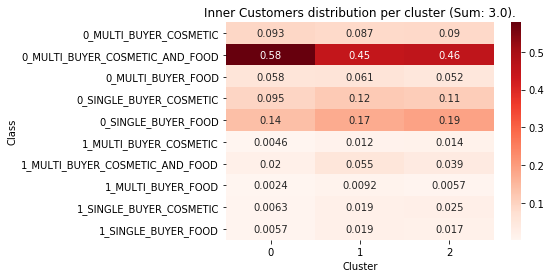



************************************************************************************
Calculate distributions for a KMean model with 4 clusters


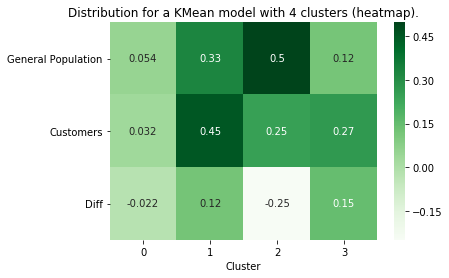

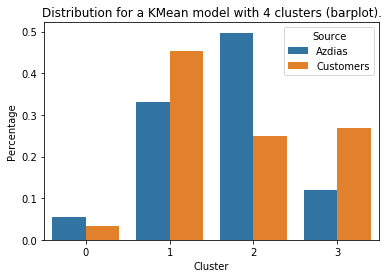

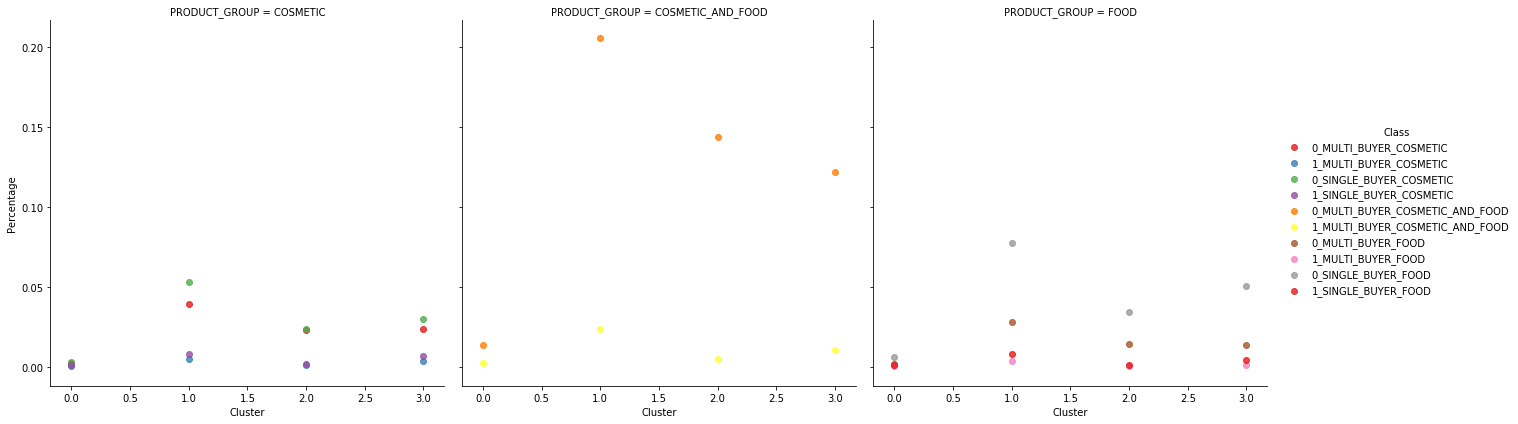

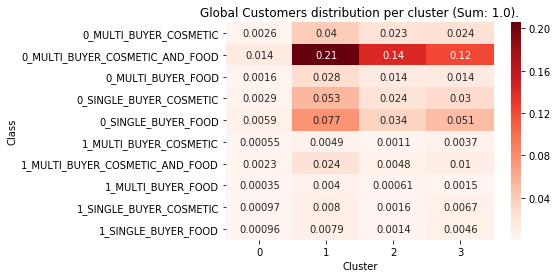

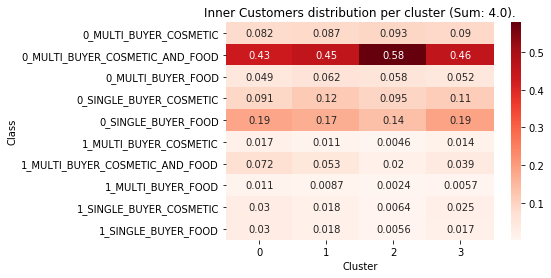



************************************************************************************
Calculate distributions for a KMean model with 5 clusters


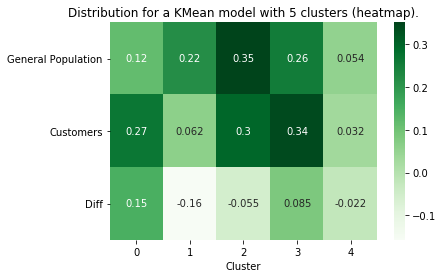

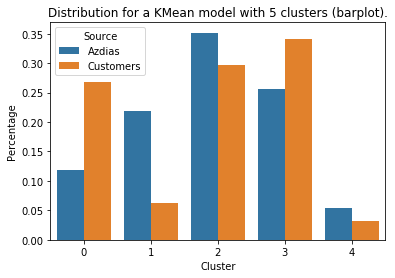

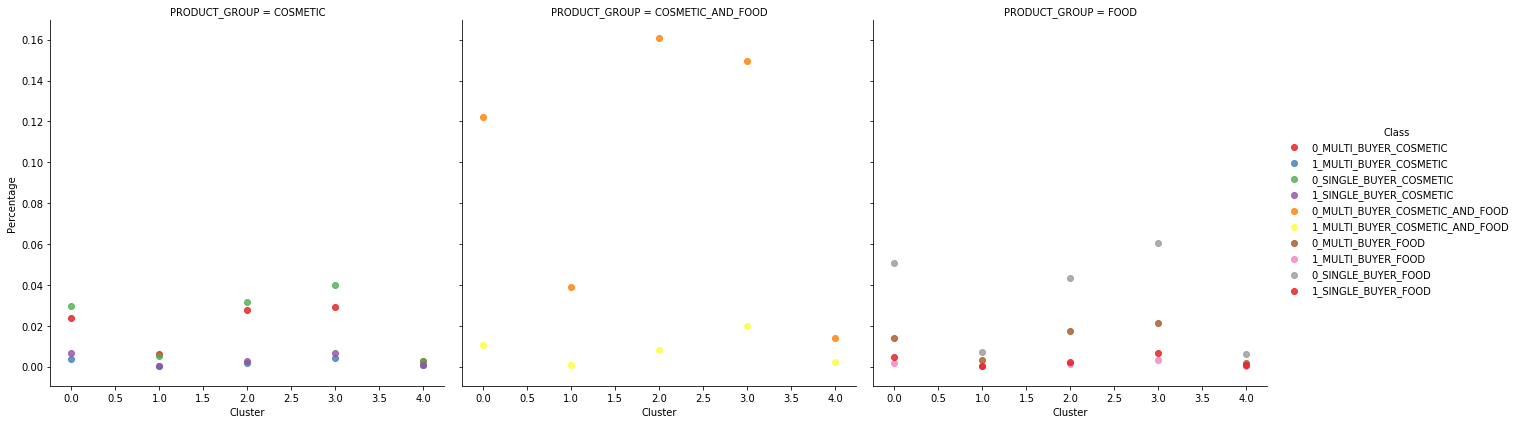

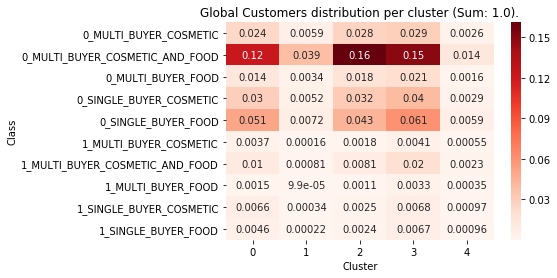

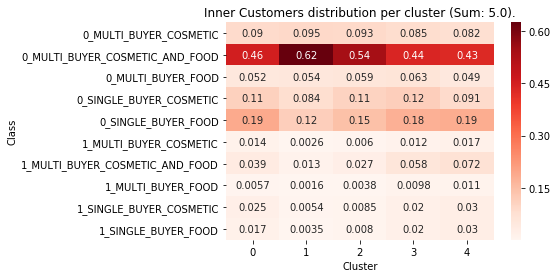

In [93]:
for n_cluster in [3, 4, 5]:
    print("\n\n************************************************************************************")
    print(f'Calculate distributions for a KMean model with {n_cluster} clusters')
    v_kmeans = v_kmeans_100[n_cluster]
    
    # We calculate the labels for the general population and the percentage covered by the cluster
    v_labelAzdias = pd.Series(v_kmeans.predict(X_pca_azdias)).value_counts().reset_index()
    v_labelAzdias.columns   = ['Cluster', 'Count']
    v_labelAzdias['Source'] = 'Azdias'
    v_labelAzdias['Percentage']  = v_labelAzdias['Count'] / X_pca_azdias.shape[0]

    # We calculate the labels for the customers and the percentage covered by the cluster
    v_labelCust = pd.Series(v_kmeans.predict(X_pca_customers)).value_counts().reset_index()
    v_labelCust.columns   = ['Cluster', 'Count']
    v_labelCust['Source'] = 'Customers'
    v_labelCust['Percentage']  = v_labelCust['Count'] / X_pca_customers.shape[0]
    
    v_perDF = pd.concat([ v_labelAzdias.groupby(['Cluster']).agg({'Percentage': ['sum']}), 
                          v_labelCust.groupby(['Cluster']).agg({'Percentage': ['sum']}) ], axis = 1)
    v_perDF.columns = ['General Population', 'Customers']
    v_perDF['Diff'] = v_perDF['Customers'] - v_perDF['General Population']
    sns.heatmap(v_perDF.T, annot = True, cmap = 'Greens')
    plt.yticks(rotation = 0) 
    plt.title(f'Distribution for a KMean model with {n_cluster} clusters (heatmap).')
    plt.show()

    v_labelDF = pd.concat([ v_labelAzdias, v_labelCust], axis = 0)     
    sns.barplot(x = 'Cluster', y = 'Percentage', hue = 'Source', data = v_labelDF)
    plt.title(f'Distribution for a KMean model with {n_cluster} clusters (barplot).')
    plt.show()
        
    # Check the cluster distribution based on the Product Group, Customer Group and Online Purchase
    v_labelCust = pd.DataFrame(v_kmeans.predict(X_pca_customers))
    v_labelCust.columns = ['Cluster']
    v_cols = ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']
    v_labelCust[v_cols] = v_customers[v_cols]
    v_labelCust = v_labelCust[v_cols + ['Cluster']]
    v_labelCust = v_labelCust.groupby(v_labelCust.columns.tolist()).agg({'Cluster': ['count']}).reset_index()
    v_labelCust.columns = v_cols + ['Cluster', 'Count']
    v_labelCust['Percentage'] = v_labelCust['Count'] / X_pca_customers.shape[0]
    
    v_lambda = lambda x: x['Count'] / ( X_pca_customers.shape[0] * v_perDF.loc[x['Cluster'], 'Customers'] )
    v_labelCust['Percentage_Inner'] = v_labelCust[['Count', 'Cluster']].apply(v_lambda, axis = 1)
    
    v_labelCust['Class'] = v_labelCust['ONLINE_PURCHASE'].astype(str) \
                              + '_' + v_labelCust['CUSTOMER_GROUP'] \
                              + '_' + v_labelCust['PRODUCT_GROUP']
    
    sns.lmplot( x = "Cluster", y = 'Percentage', hue = 'Class', data = v_labelCust, fit_reg = False, palette="Set1",
                col = "PRODUCT_GROUP", height = 6)
    plt.show()

    print('\n')
    sns.heatmap(v_labelCust.pivot("Class", "Cluster", "Percentage"), annot = True, cmap = 'Reds')
    plt.title(f'Global Customers distribution per cluster (Sum: {round(v_labelCust["Percentage"].sum())}).')
    plt.show() 

    print('\n')
    sns.heatmap(v_labelCust.pivot("Class", "Cluster", "Percentage_Inner"), annot = True, cmap = 'Reds')
    plt.title(f'Inner Customers distribution per cluster (Sum: {round(v_labelCust["Percentage_Inner"].sum())}).')
    plt.show() 

We also check the elbow method results.

[0.0,
 0.13690559200374694,
 0.8824355441758456,
 0.9803913537346665,
 0.9986570530023017,
 0.9909372691754181,
 0.9953784061528375,
 0.9898538087526646,
 0.9991828675480146,
 0.9997267093516643,
 0.9985987753775153,
 0.9998044266465045,
 0.9987799392461285,
 0.9989599560726918,
 0.9983293228771825,
 0.9998563906229965,
 0.1]

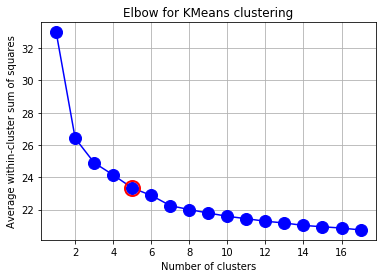

In [91]:
def elbowMethod(p_X, p_kMeansVar):
    v_Key = list(p_kMeansVar.keys())
    centroids = [p_kMeansVar[key].cluster_centers_ for key in p_kMeansVar.keys()]
    D_k = [cdist(p_X, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D, axis = 1) for D in D_k]
    dist = [np.min(D, axis = 1) for D in D_k]
    avgWithinSS = [sum(d) / p_X.shape[0] for d in dist]

    seg_threshold = 0.99

    #The angle between points
    def segments_gain(p1, v, p2):
        vp1 = np.linalg.norm(p1 - v)
        vp2 = np.linalg.norm(p2 - v)
        p1p2 = np.linalg.norm(p1 - p2)
        return np.arccos((vp1**2 + vp2**2 - p1p2**2) / (2 * vp1 * vp2)) / np.pi

    #Normalize the data
    criterion = np.array(avgWithinSS)
    criterion = (criterion - criterion.min()) / (criterion.max() - criterion.min())

    #Compute the angles
    seg_gains = np.array([0, ] 
                  + [ segments_gain(*[np.array([v_Key[j], criterion[j]]) for j in range(i - 1, i + 2)]) 
                         for i in range(len(v_Key) - 2) ] + [0.1, ])

    display(list(seg_gains))

    #Get the first index satisfying the threshold
    kIdx = np.argmax(seg_gains > seg_threshold)

    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot( v_Key, avgWithinSS, 'b*-', marker = 'o', markersize = 12 )
    ax.plot( v_Key[kIdx], 
             avgWithinSS[kIdx], 
             marker = 'o', 
             markersize = 15, 
             markeredgewidth = 2, 
             markeredgecolor = 'r', 
             markerfacecolor = 'None' )
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    return
    
elbowMethod(X_pca_azdias, v_kmeans_100)

We choose to keep 5 clusters.

In [188]:
v_kmeans = v_kmeans_100[5]

-----
### Inner distribution for clusters

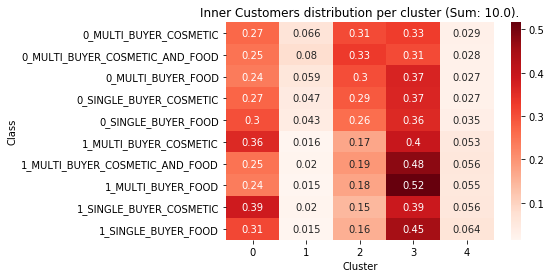

In [191]:
v_labelCust = pd.DataFrame(v_kmeans.predict(X_pca_customers))
v_labelCust.columns = ['Cluster']
v_cols = ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']
v_labelCust[v_cols] = v_customers[v_cols]
v_labelCust = v_labelCust[v_cols + ['Cluster']]

v_perDF = v_labelCust.groupby(v_cols).agg({'Cluster': ['count']}).reset_index()
v_perDF.columns = v_cols + ['Total Count']

v_labelCust = v_labelCust.groupby(v_labelCust.columns.tolist()).agg({'Cluster': ['count']}).reset_index()
v_labelCust.columns = v_cols + ['Cluster', 'Count']
v_labelCust = v_labelCust.merge(v_perDF, how = 'inner', on = v_cols)

v_lambda = lambda x: x['Count'] / ( X_pca_customers.shape[0] * v_perDF.loc[x['Cluster'], 'Customers'] )
v_labelCust['Percentage_Inner'] = v_labelCust['Count'] / v_labelCust['Total Count']

v_labelCust['Class'] = v_labelCust['ONLINE_PURCHASE'].astype(str) \
                              + '_' + v_labelCust['CUSTOMER_GROUP'] \
                              + '_' + v_labelCust['PRODUCT_GROUP']

print('\n')
sns.heatmap(v_labelCust.pivot("Class", "Cluster", "Percentage_Inner"), annot = True, cmap = 'Reds')
plt.title(f'Inner Customers distribution per cluster (Sum: {round(v_labelCust["Percentage_Inner"].sum())}).')
plt.show() 

----
### Identify profiles in the clusters



*********************************************************************************
PCA for cluster 0:


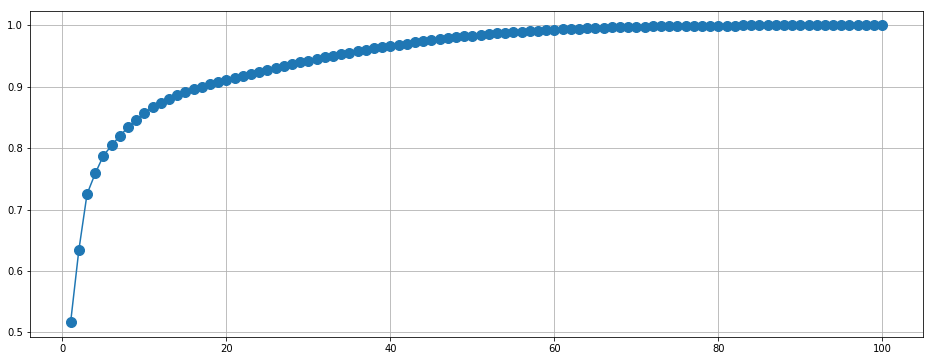

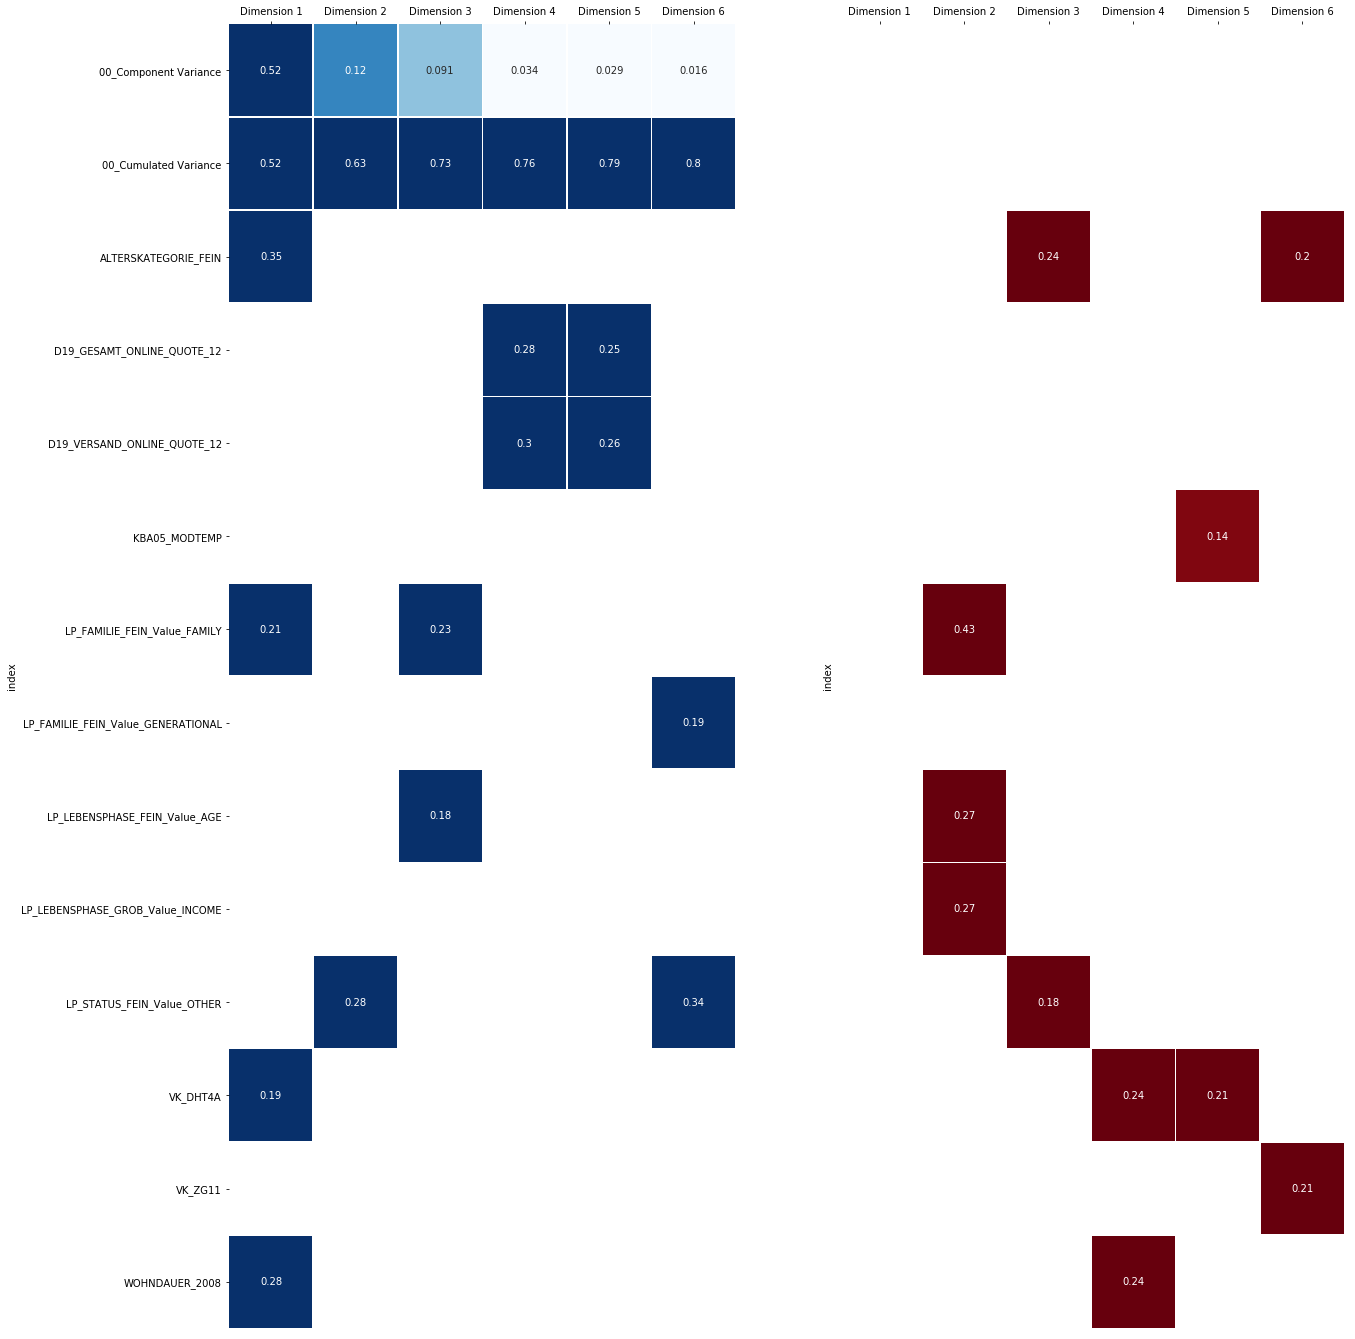



*********************************************************************************
PCA for cluster 2:


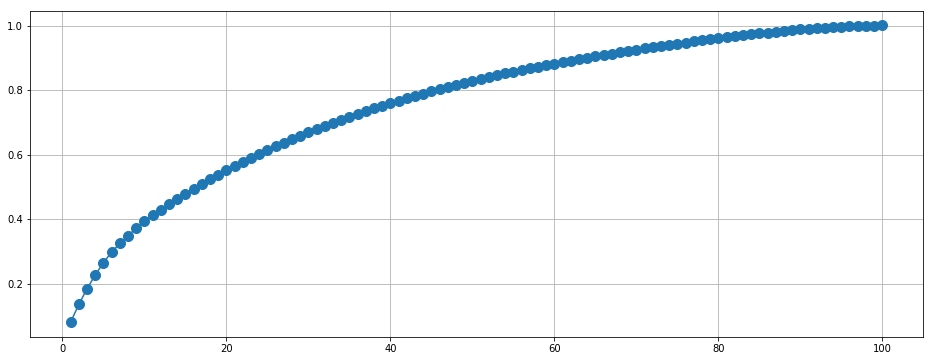

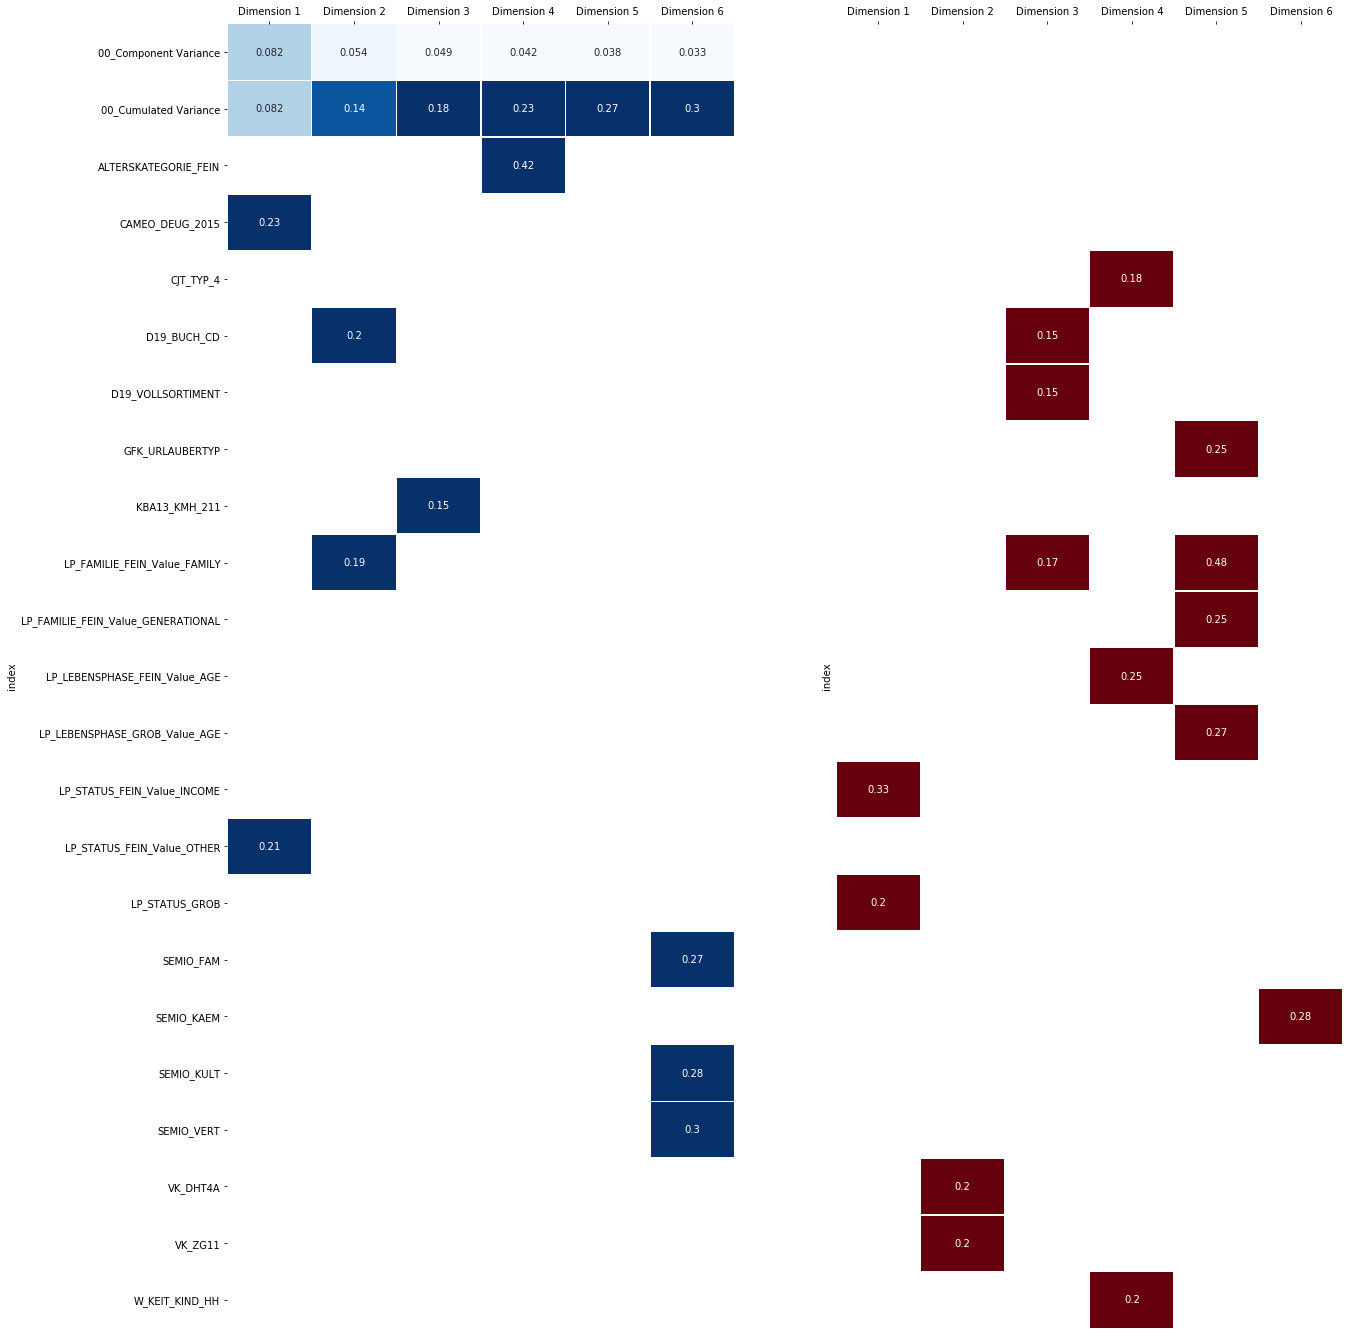



*********************************************************************************
PCA for cluster 3:


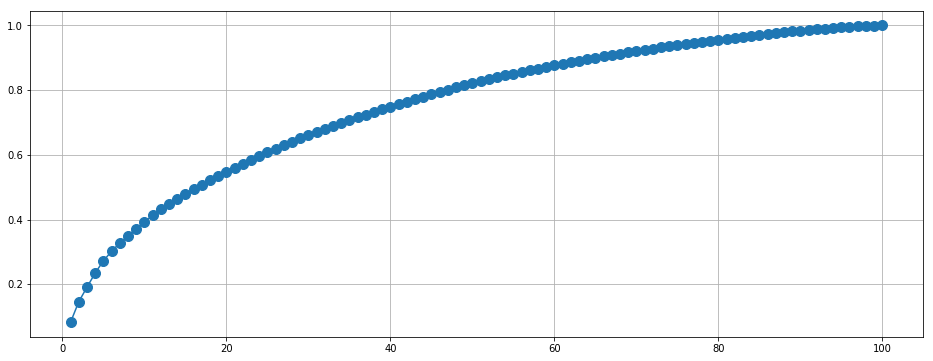

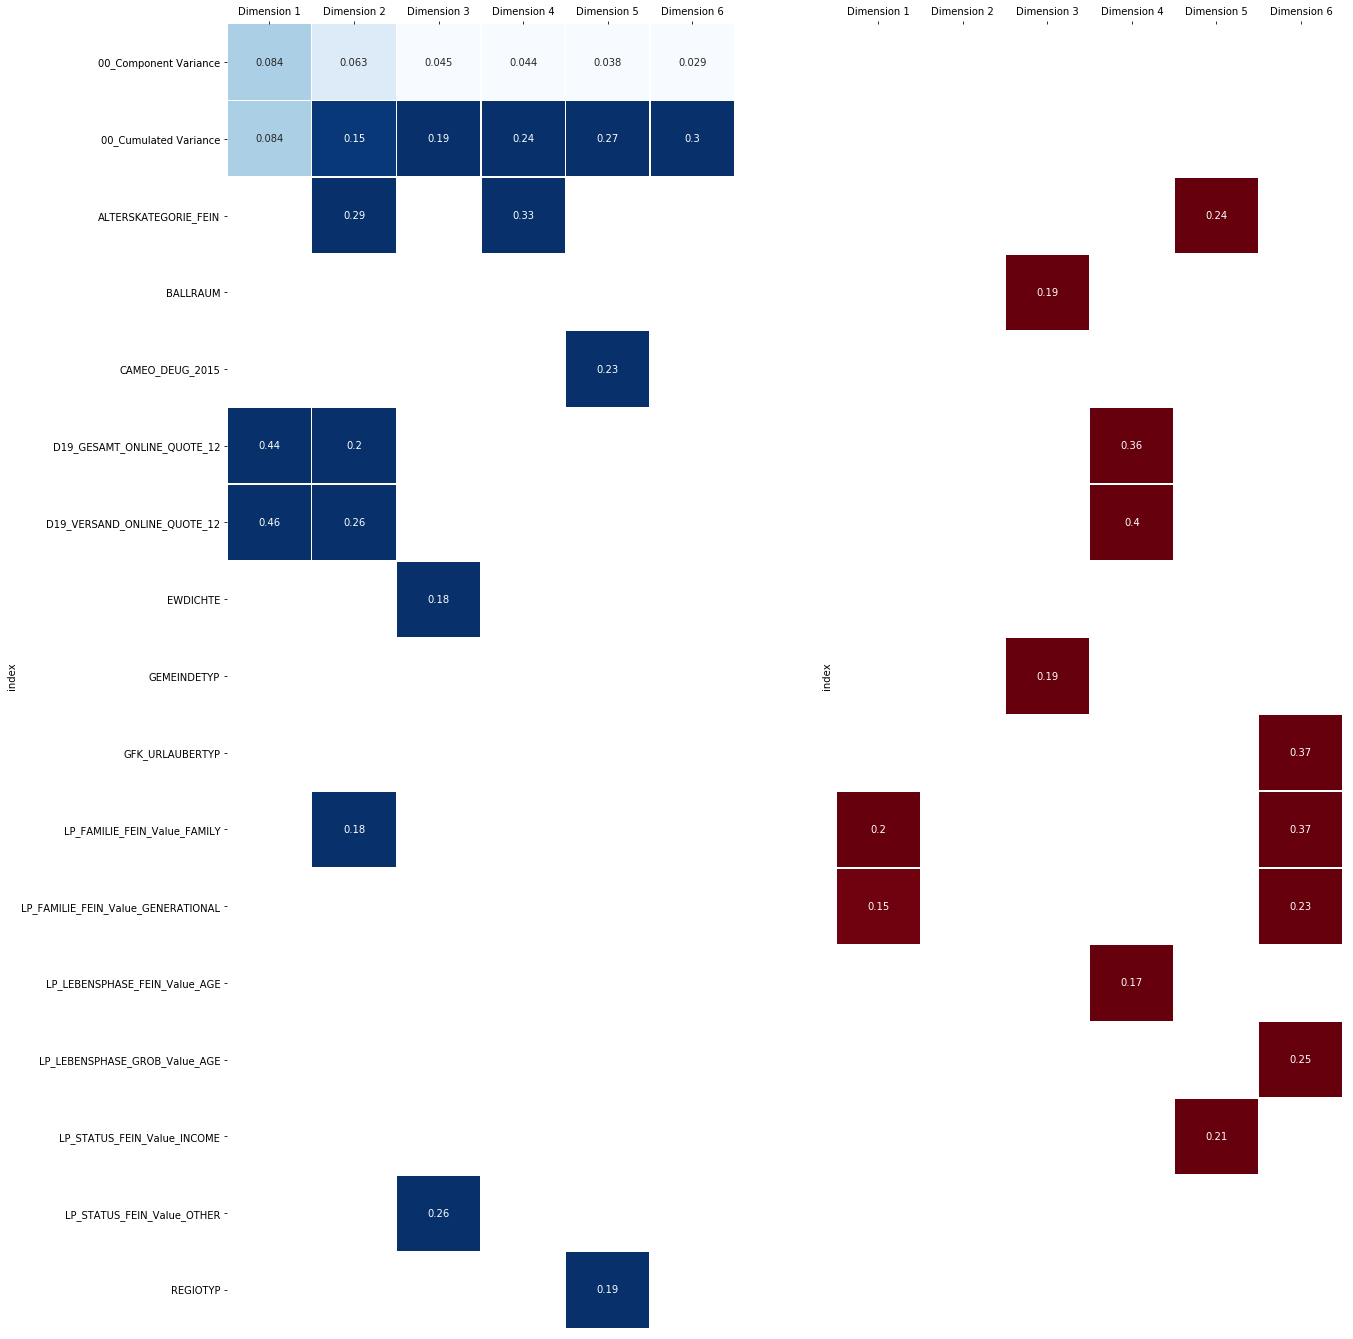

In [95]:
def displayProfiles( p_kmean, 
                     p_pca,
                     p_columns,
                     X_pca,
                     p_threshold = 0.1,
                     p_n_components = 100 ):
    v_data = pd.DataFrame(p_pca.inverse_transform(X_pca), columns = p_columns)       
    v_data['Cluster'] = v_kmeans.predict(X_pca)
    
    v_perc = v_data.groupby(['Cluster']).agg({'Cluster': ['count']}) / X_pca.shape[0]
    v_perc.columns = ['Percentage']
    
    for cluster in v_perc[v_perc['Percentage'] > p_threshold].index: 
        print('\n\n*********************************************************************************')
        print(f'PCA for cluster {cluster}:')
        _ = utl_applyPCA( p_data         = v_data[v_data['Cluster'] == cluster],
                          p_n_components = p_n_components,
                          p_ShowWeights  = True,
                          p_ShowTop      = 6,
                          p_figHeight    = 24 )
    return

displayProfiles( p_kmean        = v_kmeans,
                 p_pca          = g_pcaAzdias,
                 p_columns      = X_azdias.columns,
                 X_pca          = X_pca_customers,
                 p_n_components = 100 )

Save the PCA, scalers and KMean model.

In [101]:
joblib.dump(g_pcaAzdias, g_saveFilenames['pcaAzdias'])
joblib.dump(v_scalers, g_saveFilenames['pcaAzdias_scalers'])
joblib.dump(v_kmeans, g_saveFilenames['KMean'])

['saveGlobals/KMean.sav']

---
---
---

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [102]:
g_pcaAzdias         = joblib.load(g_saveFilenames['pcaAzdias'])
g_pcaAzdias_scalers = joblib.load(g_saveFilenames['pcaAzdias_scalers'])
g_KMean             = joblib.load(g_saveFilenames['KMean'])

In [103]:
for path in [ '../Arvato Project - dataSensitive', '../../data/Term2/capstone/arvato_data' ]:
    try:
        mailout_train = pd.read_csv(f'{path}/Udacity_MAILOUT_052018_TRAIN.csv', sep=';').drop('Unnamed: 0', axis = 1)
        break
    except: None
    
v_mailout_train, v_missing, v_scaleColumns = utl_cleanDataFrame( p_label          = 'Train Dataset', 
                                                                 p_data           = mailout_train, 
                                                                 p_saveFilenames  = g_saveFilenames,
                                                                 p_ignoreScale    = [ 'LNR', 'RESPONSE' ] )

C:\Lisaro\___winApp\Anaconda\envs\pyTorchVision\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



********************************************************************************************


START Clean dataframe **<span style="color: blue">Train Dataset</span>**.

Clean dataframe **<span style="color: blue">Train Dataset</span>** based on definition.

Re-encode columns values based on definition.

100% (314 of 314) |######################| Elapsed Time: 0:00:31 Time:  0:00:31


Transform object columns to numeric.

100% (23 of 23) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



********************************************************************************************


Reduce memory usage for dataframe **<span style="color: blue">Train Dataset</span>**.

  1% (5 of 391) |                        | Elapsed Time: 0:00:00 ETA:   0:00:09

Initial memory usage is 106.61 MBs.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 42962 entries, 0 to 42961
Columns: 391 entries, LNR to PRAEGENDE_JUGENDJAHRE_Value_3
dtypes: float16(89), float64(194), int64(87), object(21)
memory usage: 106.6+ MB
None


100% (391 of 391) |######################| Elapsed Time: 0:00:04 Time:  0:00:04



Final memory usage is 33.35 MBs.
This is 31.28% of the initial size.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42962 entries, 0 to 42961
Columns: 391 entries, LNR to PRAEGENDE_JUGENDJAHRE_Value_3
dtypes: float16(264), int8(6), object(21), uint16(1), uint32(1), uint8(98)
memory usage: 33.4+ MB
None


Re-encode column **<span style="color: blue">EINGEFUEGT_AM</span>**.

Re-encode outliers.

Re-encode column having year format **<span style="color: blue">EINGEZOGENAM_HH_JAHR</span>**.

Re-encode column having year format **<span style="color: blue">GEBURTSJAHR</span>**.

Re-encode column having year format **<span style="color: blue">MIN_GEBAEUDEJAHR</span>**.

Re-encode column having year format **<span style="color: blue">EINGEFUEGT_AM_Year</span>**.

Apply mapping for column: **<span style="color: blue">EXTSEL992</span>**.

Calculate the reduced dimension flags for **<span style="color: blue">MISSING</span>** and **<span style="color: blue">UNKNOWN</span>** values.

Concatenate the calculated missing / unknonw with reduced dimension.

Re-encode some categorical columns.

Dummy encode the object columns not re-encoded above.

Fill in categorical columns with -2.

Drop features identified as highly correlated.

Calculate columns to be imputed later.

Calculate columns to be scaled later.


********************************************************************************************


END Clean dataframe **<span style="color: blue">Train Dataset</span>**.

In [104]:
X_train, _ = utl_scaleImpute( X_data          = v_mailout_train.drop([ 'LNR', 'RESPONSE' ], axis = 1), 
                              p_imputeColumns = v_missing, 
                              p_scaleColumns  = v_scaleColumns,
                              p_scalers       = g_pcaAzdias_scalers )
X_pca_train = pd.DataFrame(g_pcaAzdias.transform(X_train))
X_pca_train.columns = [f'Dimension_{item}' for item in X_pca_train.columns]
v_mailout_train['Cluster'] = g_KMean.predict(X_pca_train)

------
### Split in train and test datasets

In [107]:
from sklearn.model_selection import train_test_split

v_features = v_mailout_train.drop(['RESPONSE', 'LNR'], axis = 1)
v_target   = v_mailout_train['RESPONSE']
X_trainAll, X_testAll, y_trainAll, y_testAll = train_test_split( v_features, 
                                                                 v_target, 
                                                                 test_size = .10, 
                                                                 random_state = 42,
                                                                 stratify = v_target )

------
### Define the weight for the positive class.

In [108]:
print('Positive weight for the complete target: ', round(float(np.sum(v_target == 0)) / np.sum(v_target == 1), 3))
print('Positive weight for the train dataset:   ', round(float(np.sum(y_trainAll == 0)) / np.sum(y_trainAll == 1), 3))
print('Positive weight for the test dataset:    ', round(float(np.sum(y_testAll == 0)) / np.sum(y_testAll == 1), 3))
v_posWeight = 79.75

Positive weight for the complete target:  79.756
Positive weight for the train dataset:    79.72
Positive weight for the test dataset:     80.075


---
### Create base LGB model

We create a LGB model trained with default parameters in order to use it in the benchmarking.

Class has been initialized for model type: lightgbm
   ROC / AUC score: 0.99382.


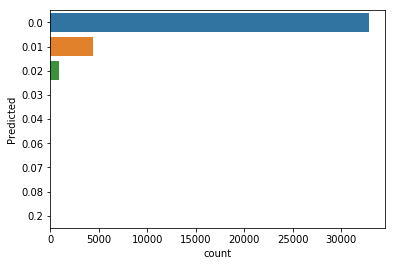

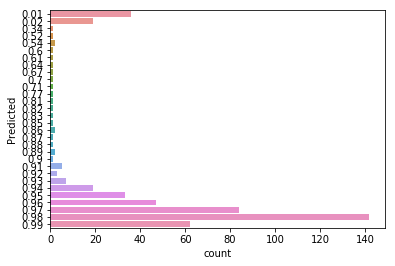

,True,Predicted
9101,1,0.81
40103,1,0.01
42054,1,0.98
22638,1,0.83
3259,1,0.96


   ROC / AUC score: 0.710319.


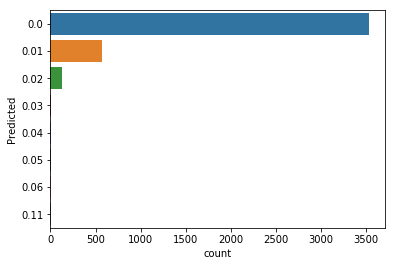

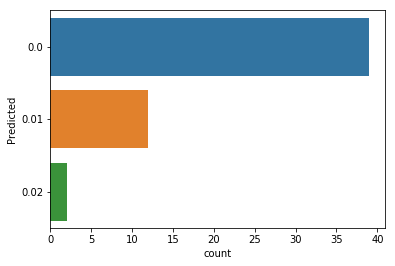

,True,Predicted
41549,1,0.00
31012,1,0.02
22664,1,0.00
25505,1,0.00
32156,1,0.00


array([1.09024201e-03, 2.73717552e-04, 3.57773378e-05, ...,
       2.36876713e-05, 4.08864779e-04, 5.64327751e-05])

In [129]:
v_model = CustBoostClassifier( p_modelType          = 'lightgbm',
                               p_modelName          = 'LGB_Benchmark',
                               X_train              = X_trainAll.copy(),
                               y_train              = y_trainAll.copy(),
                               p_selected_features  = [],
                               p_imputeColumns      = [], 
                               p_scaleColumns       = [], 
                               p_cvSplits           = 0,
                               p_random_state       = 2013 ) 
v_model.train({ 'objective':      'binary',
                'metric':         'auc',
                'learning_rate':  0.01 })
v_model.predictProba( X_data      = X_trainAll.copy(), 
                      y_data      = y_trainAll.copy(), 
                      p_showPlot  = True )
v_model.predictProba( X_data      = X_testAll.copy(), 
                      y_data      = y_testAll.copy(), 
                      p_showPlot  = True )

------
### Bayesian search for parameters for LGB models with all features, no imputing, no scaling

In [121]:
v_hyper_space = { 'objective':           'binary',
                  'n_estimators': 1000 + hp.randint('n_estimators', 1500),               
                  'boosting_type': hp.choice('boosting_type', [
                                                         { 'boosting_type': 'gbdt', 
                                                           'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                         { 'boosting_type': 'dart', 
                                                           'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                         { 'boosting_type': 'goss'} ]),
                  'max_depth':         hp.quniform('max_depth', 1, 30, 1),
                  'scale_pos_weight':  hp.quniform('scale_pos_weight', v_posWeight * 0.5, 
                                                                       v_posWeight * 2, 
                                                                       v_posWeight * 0.5),
                  'num_leaves':        hp.quniform('num_leaves', 2, 150, 1),
                  'learning_rate':     hp.loguniform('learning_rate', np.log(0.00001), np.log(0.0075)),
                  'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
                  'reg_alpha':         hp.uniform('reg_alpha', 0.0, 1.0),
                  'reg_lambda':        hp.uniform('reg_lambda', 0.0, 1.0),
                  'colsample_bytree':  hp.uniform('colsample_by_tree', 0.6, 1.0) }  

v_model = CustBoostClassifier( p_modelType          = 'lightgbm',
                               p_modelName          = 'LGB_AllFeatures_NI_NS',
                               X_train              = X_trainAll.copy(),
                               y_train              = y_trainAll.copy(),
                               p_selected_features  = [],
                               p_imputeColumns      = [], 
                               p_scaleColumns       = [], 
                               p_cvSplits           = 10,
                               p_random_state       = 2013 )   
v_bayes_trials = v_model.bayesianSearchLGB( p_hyper_space = v_hyper_space,
                                            p_posWeight   = v_posWeight,
                                            p_max_eval    = 900,
                                            X_test        = X_testAll, 
                                            y_test        = y_testAll )
print('Bayesian Search ended.')

v_stackDir = v_model.copyStackModels(p_top = 10, p_suffix = '10')
print(f'New stack directory created (top 10): {v_stackDir}')

v_stackDir = v_model.copyStackModels(p_top = 20, p_suffix = '20')
print(f'New stack directory created (top 20): {v_stackDir}')

v_stackDir = v_model.copyStackModels(p_top = 30, p_suffix = '30')
print(f'New stack directory created (top 30): {v_stackDir}')

v_stackDir = v_model.copyStackModels(p_top = 60, p_suffix = '60')
print(f'New stack directory created (top 60): {v_stackDir}')

v_stackDir = v_model.copyStackModels(p_top = 100, p_suffix = '100')
print(f'New stack directory created (top 100): {v_stackDir}')

v_now      = datetime.datetime.today().strftime('%Y%m%d_%H%M')
v_fileName = f'models/gbm_trials/__search_{v_now}.json'
with open(v_fileName, 'w+') as outFile:
    json.dump(v_bayes_trials, outFile)

Execute CV split.
Class has been initialized for model type: lightgbm
Bayesian Search ended.

***********************************************************************************************
New stack directory created (top 10): LGB_AllFeatures_NI_NS_20181210_0128_10

***********************************************************************************************
New stack directory created (top 20): LGB_AllFeatures_NI_NS_20181210_0128_20

***********************************************************************************************
New stack directory created (top 30): LGB_AllFeatures_NI_NS_20181210_0128_30

***********************************************************************************************
New stack directory created (top 60): LGB_AllFeatures_NI_NS_20181210_0128_60

***********************************************************************************************
New stack directory created (top 100): LGB_AllFeatures_NI_NS_20181210_0129_100


-----
#### Visualize the distibution of the scores for the different hyperparameters

We visualize the distribution of validation and test scores for different values for the hyper-parameters.

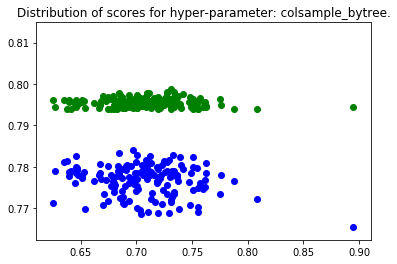

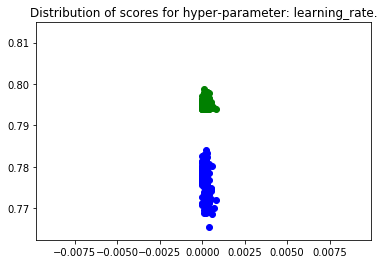

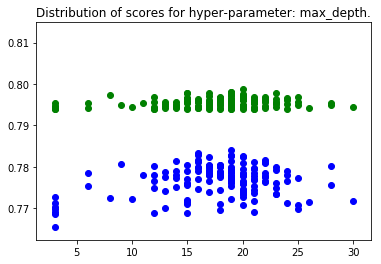

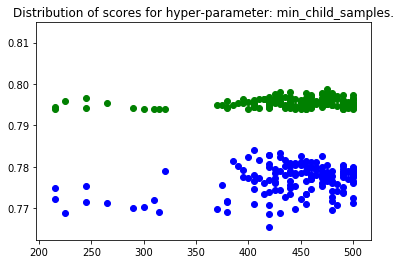

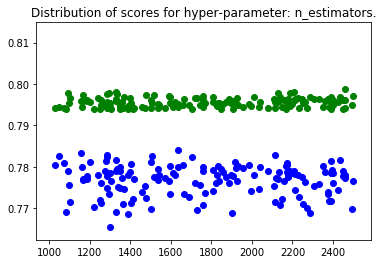

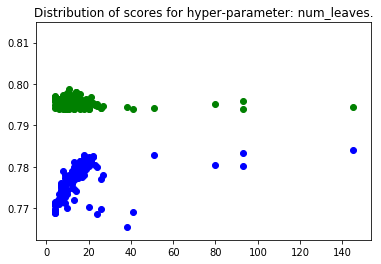

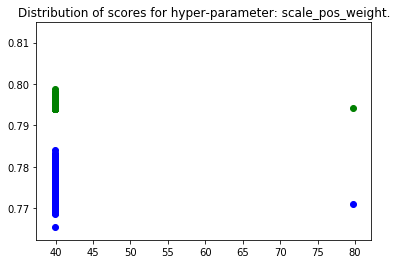

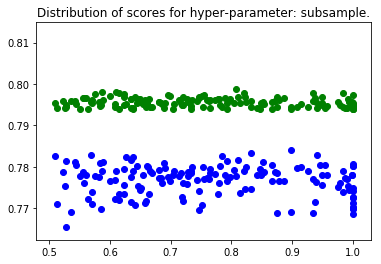

In [125]:
for key in [ 'colsample_bytree', 'learning_rate', 'max_depth', 'min_child_samples', 'n_estimators', 'num_leaves',
             'scale_pos_weight', 'subsample' ]:
    for item in v_bayes_trials[:150]:
        plt.scatter(round(item['params'][key], 4), item['scoreValid'], c = "g")
        plt.scatter(round(item['params'][key], 4), item['scoreTest'],  c = "b")
    plt.title(f'Distribution of scores for hyper-parameter: {key}.')
    plt.show()

We can see that for the best 150 trials we have: 
   - a learning rate lower than 0.0075
   - the optimal number of leaves lower than 40
   - the optimal number of column samples by tree between 0.65 and 0.86
   - the optimal number for reg lambda lower than 0.5
   
The Bayesian did not find an optimum after 900 trials, so we should do a new search for finding the optimal model by narrowing the possible values / ranges for the hyper-parameters.

-----
#### Make predictions with best stack models

We make predictions with the best 10, 20, 30, 60 and 100 models.



**********************************************************************************
Make predictions for train and test dataset by using the best 10 stacked models.
Class has been initialized for model type: lightgbm
   ROC / AUC score: 0.843539.


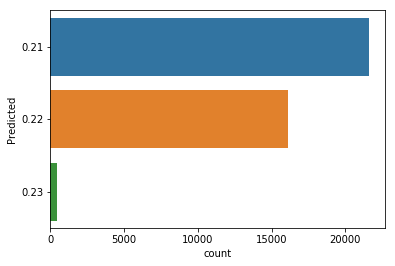

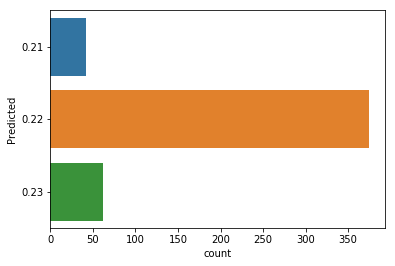

,True,Predicted
9101,1,0.22
40103,1,0.22
42054,1,0.22
22638,1,0.22
3259,1,0.22


   ROC / AUC score: 0.780174.


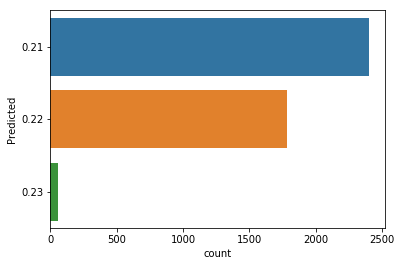

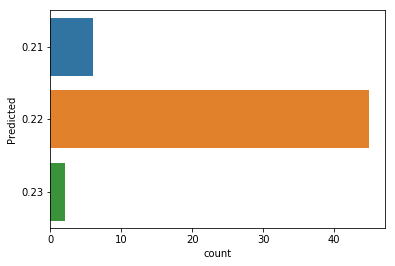

,True,Predicted
41549,1,0.22
31012,1,0.22
22664,1,0.22
25505,1,0.23
32156,1,0.21




**********************************************************************************
Make predictions for train and test dataset by using the best 20 stacked models.
Class has been initialized for model type: lightgbm
   ROC / AUC score: 0.839458.


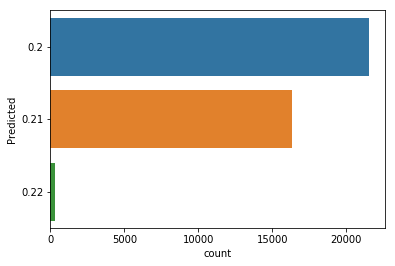

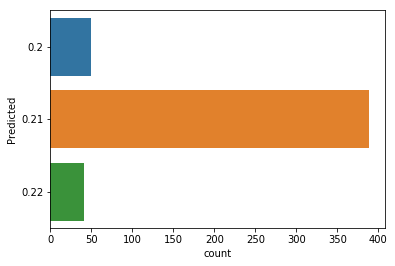

,True,Predicted
9101,1,0.21
40103,1,0.21
42054,1,0.21
22638,1,0.21
3259,1,0.21


   ROC / AUC score: 0.779013.


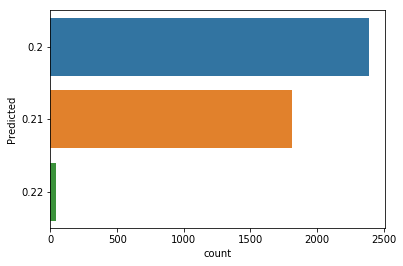

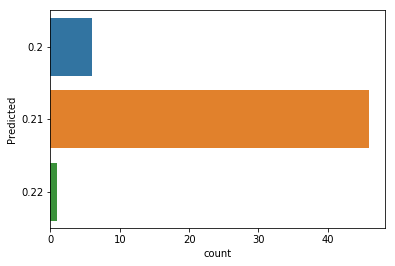

,True,Predicted
41549,1,0.21
31012,1,0.21
22664,1,0.21
25505,1,0.22
32156,1,0.20




**********************************************************************************
Make predictions for train and test dataset by using the best 30 stacked models.
Class has been initialized for model type: lightgbm
   ROC / AUC score: 0.837116.


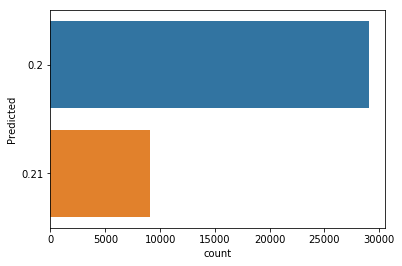

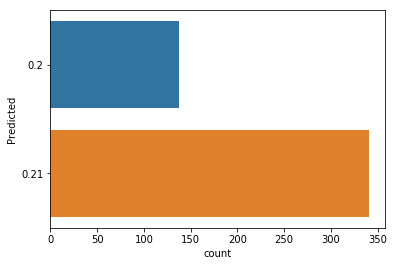

,True,Predicted
9101,1,0.20
40103,1,0.20
42054,1,0.21
22638,1,0.20
3259,1,0.21


   ROC / AUC score: 0.778395.


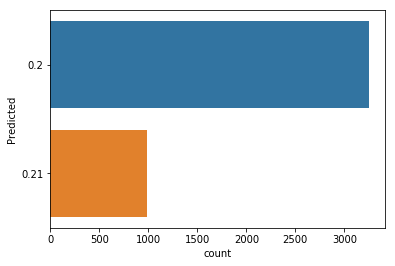

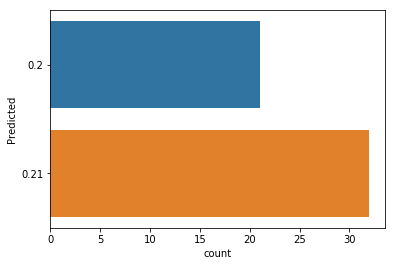

,True,Predicted
41549,1,0.21
31012,1,0.20
22664,1,0.21
25505,1,0.21
32156,1,0.20


In [152]:
v_models = {}
for item in [ (10,  'LGB_AllFeatures_NI_NS_20181210_0128_10'),
              (20,  'LGB_AllFeatures_NI_NS_20181210_0128_20'),
              (30,  'LGB_AllFeatures_NI_NS_20181210_0128_30') ]:
    print('\n\n**********************************************************************************')
    print(f'Make predictions for train and test dataset by using the best {item[0]} stacked models.')
    #v_stackDir = ['LGB_AllFeatures_NI_NS_20181204_1858']
    v_models[item[0]] = CustBoostClassifier( p_modelType          = 'lightgbm',
                                             p_random_state       = 2013 ) 
    y_pred = v_models[item[0]].predictStack( p_folder   = [item[1]],
                                   X_data     = X_trainAll, 
                                   y_data     = y_trainAll, 
                                   p_showPlot = True )   
    y_pred = v_models[item[0]].predictStack( p_folder   = [item[1]],
                                   X_data     = X_testAll, 
                                   y_data     = y_testAll, 
                                   p_showPlot = True )

----
#### Calculate the 30 most important features, based on the models above

In [159]:
v_model = CustBoostClassifier( p_modelType          = 'lightgbm',
                               p_random_state       = 2013 )
v_mainFeatures = v_model.featureImportanceStack( p_folder = ['LGB_AllFeatures_NI_NS_20181210_0128_10'],
                                                 p_top    = 30 )

Class has been initialized for model type: lightgbm


,feature,_importance_split,_importance_gain
0,D19_SOZIALES,68.72,5.378360e+06
1,KBA13_ALTERHALTER_30,29.46,4.613721e+05
2,D19_KONSUMTYP_MAX,12.22,4.173576e+05
3,EINGEZOGENAM_HH_JAHR,24.75,9.768980e+04
4,_isMissingUnknown_17,14.90,7.922488e+04
5,_isMissingUnknown_10,16.79,7.912329e+04
6,D19_KONSUMTYP,3.04,6.712498e+04
7,ALTERSKATEGORIE_FEIN,9.57,6.669933e+04
8,ANZ_HH_TITEL,3.73,5.625880e+04
9,_isMissingUnknown_9,15.27,5.170534e+04


---
### Explain predictions

In order to explain the predictions for the models, we will train a new model by using the best parameters found through the Bayesian search and use SHAP values at global and local level.

In [171]:
v_bayes_trials[:1]

[{'loss': 0.20128342811115985,
  'params': {'boosting_type': 'dart',
   'colsample_bytree': 0.7308854156761736,
   'learning_rate': 0.00010319300479136078,
   'max_depth': 20,
   'min_child_samples': 475,
   'n_estimators': 2461,
   'num_leaves': 11,
   'objective': 'binary',
   'reg_alpha': 0.24650068380014456,
   'reg_lambda': 0.0017020383398983442,
   'scale_pos_weight': 39.875,
   'subsample': 0.807082527091483},
  'status': 'ok',
  'iteration': 759,
  'train_time': 59.582883577095345,
  'scoreValid': 0.7987165718888402,
  'scoreTest': 0.7777461632849039}]

Class has been initialized for model type: lightgbm
   ROC / AUC score: 0.827257.


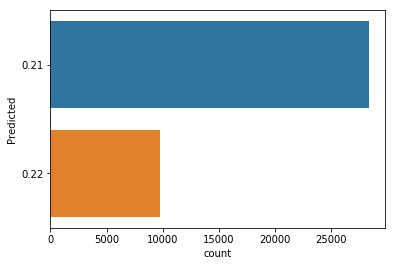

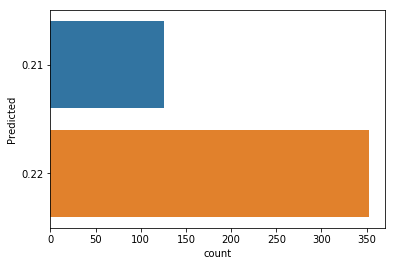

,True,Predicted
9101,1,0.22
40103,1,0.21
42054,1,0.22
22638,1,0.22
3259,1,0.22


   ROC / AUC score: 0.781936.


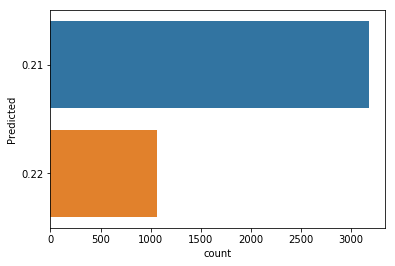

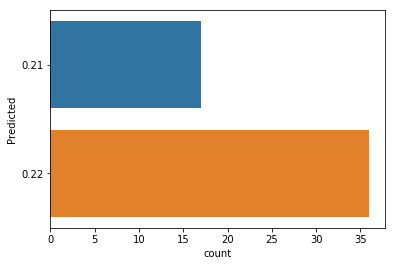

,True,Predicted
41549,1,0.22
31012,1,0.21
22664,1,0.22
25505,1,0.22
32156,1,0.21


array([0.21392938, 0.21843028, 0.21107824, ..., 0.21232121, 0.21773819,
       0.21129081])

In [174]:
v_model = CustBoostClassifier( p_modelType          = 'lightgbm',
                               p_modelName          = 'LGB_Benchmark',
                               X_train              = X_trainAll.copy(),
                               y_train              = y_trainAll.copy(),
                               p_selected_features  = [],
                               p_imputeColumns      = [], 
                               p_scaleColumns       = [], 
                               p_cvSplits           = 0,
                               p_random_state       = 2013 ) 
v_params = { 'boosting_type': 'dart', 
             'colsample_bytree': 0.7308854156761736, 
             'learning_rate': 0.00010319300479136078, 
             'max_depth': 20, 'min_child_samples': 475, 
             'n_estimators': 2461, 
             'num_leaves': 11, 
             'objective': 'binary', 
             'reg_alpha': 0.24650068380014456, 
             'reg_lambda': 0.0017020383398983442, 
             'scale_pos_weight': 39.875, 
             'subsample': 0.807082527091483 }
v_model.train(v_params)
v_model.predictProba( X_data      = X_trainAll.copy(), 
                      y_data      = y_trainAll.copy(), 
                      p_showPlot  = True )
v_model.predictProba( X_data      = X_testAll.copy(), 
                      y_data      = y_testAll.copy(), 
                      p_showPlot  = True )

We check the prediction explanations at global level:

In [199]:
X_data = X_trainAll.copy()
X_data['Target'] = y_trainAll
X_data.reset_index(drop = True, inplace = True)

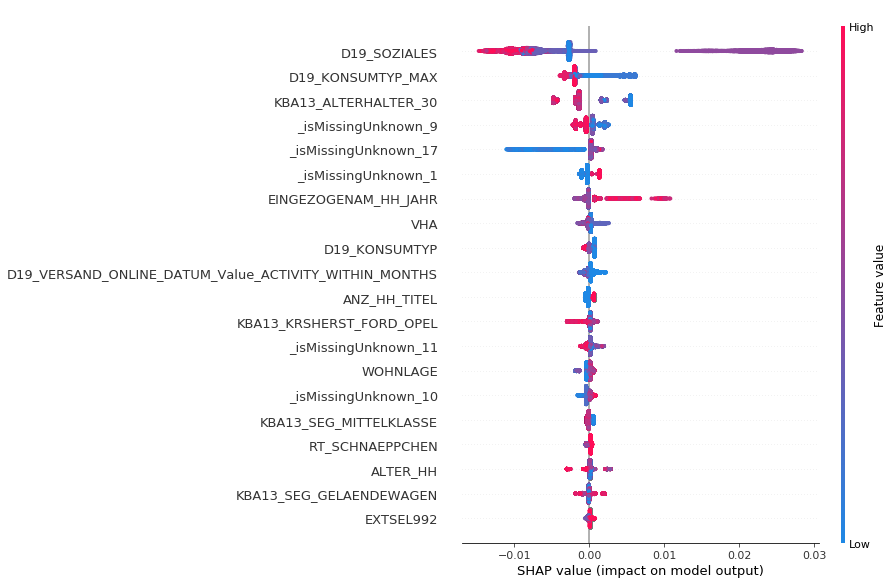

In [200]:
explainer = shap.TreeExplainer(v_model.getOneModel())
shap_values = explainer.shap_values(X_data.drop('Target', axis = 1))
shap.summary_plot(shap_values, X_data.drop('Target', axis = 1))

We check the prediction explanations at local level:

In [220]:
v_count = 0
for idx in range(X_data.shape[0]):
    if X_data.iloc[idx, :]['Target'] == 1:
        print(f'Index: {idx}')        
        v_count += 1        
        if v_count > 6: break

Index: 214
Index: 306
Index: 310
Index: 323
Index: 353
Index: 498
Index: 665


In [221]:
shap.force_plot( explainer.expected_value, shap_values[214, :], X_data.drop('Target', axis = 1).iloc[214, :] )

In [219]:
shap.force_plot( explainer.expected_value, shap_values[306, :], X_data.drop('Target', axis = 1).iloc[306, :] )

In [222]:
shap.force_plot( explainer.expected_value, shap_values[665, :], X_data.drop('Target', axis = 1).iloc[665, :] )

-----
----
----

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [160]:
for path in [ '../Arvato Project - dataSensitive', '../../data/Term2/capstone/arvato_data' ]:
    try:
        mailout_test = pd.read_csv(f'{path}/Udacity_MAILOUT_052018_TEST.csv', sep=';').drop('Unnamed: 0', axis = 1)
        break
    except: None
        
# Load variables saved earlier
v_pcaMissingUnknown = joblib.load(g_saveFilenames['pcaMissingUnknown'])

with open(g_saveFilenames['featuresDef'], 'r') as inFile:
    v_featuresDef = json.load(inFile)
    
with open(g_saveFilenames['categoricalColumns'], 'r') as inFile:
    v_categoricalColumns = json.load(inFile)
    
with open(g_saveFilenames['categoricalToProcess'], 'r') as inFile:
    v_categoricalToProcess = json.load(inFile)
    
with open(g_saveFilenames['dummyEncode'], 'r') as inFile:
    v_dummyEncode = json.load(inFile)
    
with open(g_saveFilenames['highlyCorrelated'], 'r') as inFile:
    v_highlyCorrelated = json.load(inFile)
    
with open(g_saveFilenames['colMissing'], 'r') as inFile:
    v_colMissing = json.load(inFile)
    
with open(g_saveFilenames['colUnknownVals'], 'r') as inFile:
    v_colUnknownVals = json.load(inFile)
    
v_mailout_test, v_missing, v_scaleColumns = utl_cleanDataFrame( p_label          = 'Test Dataset', 
                                                                p_data           = mailout_test, 
                                                                p_saveFilenames  = g_saveFilenames,
                                                                p_ignoreScale    = [ 'LNR' ] )

C:\Lisaro\___winApp\Anaconda\envs\pyTorchVision\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



********************************************************************************************


START Clean dataframe **<span style="color: blue">Test Dataset</span>**.

Clean dataframe **<span style="color: blue">Test Dataset</span>** based on definition.

Re-encode columns values based on definition.

100% (314 of 314) |######################| Elapsed Time: 0:00:30 Time:  0:00:30


Transform object columns to numeric.

100% (23 of 23) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



********************************************************************************************


Reduce memory usage for dataframe **<span style="color: blue">Test Dataset</span>**.

Initial memory usage is 105.96 MBs.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 42833 entries, 0 to 42832
Columns: 390 entries, LNR to PRAEGENDE_JUGENDJAHRE_Value_3
dtypes: float16(89), float64(194), int64(86), object(21)
memory usage: 106.0+ MB
None


100% (390 of 390) |######################| Elapsed Time: 0:00:04 Time:  0:00:04



Final memory usage is 33.21 MBs.
This is 31.34% of the initial size.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42833 entries, 0 to 42832
Columns: 390 entries, LNR to PRAEGENDE_JUGENDJAHRE_Value_3
dtypes: float16(264), int8(6), object(21), uint16(1), uint32(1), uint8(97)
memory usage: 33.2+ MB
None


Re-encode column **<span style="color: blue">EINGEFUEGT_AM</span>**.

Re-encode outliers.

Re-encode column having year format **<span style="color: blue">EINGEZOGENAM_HH_JAHR</span>**.

Re-encode column having year format **<span style="color: blue">GEBURTSJAHR</span>**.

Re-encode column having year format **<span style="color: blue">MIN_GEBAEUDEJAHR</span>**.

Re-encode column having year format **<span style="color: blue">EINGEFUEGT_AM_Year</span>**.

Apply mapping for column: **<span style="color: blue">EXTSEL992</span>**.

Calculate the reduced dimension flags for **<span style="color: blue">MISSING</span>** and **<span style="color: blue">UNKNOWN</span>** values.

Concatenate the calculated missing / unknonw with reduced dimension.

Re-encode some categorical columns.

Dummy encode the object columns not re-encoded above.

Fill in categorical columns with -2.

Drop features identified as highly correlated.

Calculate columns to be imputed later.

Calculate columns to be scaled later.


********************************************************************************************


END Clean dataframe **<span style="color: blue">Test Dataset</span>**.

In [163]:
X_test, _ = utl_scaleImpute( X_data          = v_mailout_test.drop([ 'LNR' ], axis = 1), 
                             p_imputeColumns = v_missing, 
                             p_scaleColumns  = v_scaleColumns,
                             p_scalers       = g_pcaAzdias_scalers )
X_pca_test = pd.DataFrame(g_pcaAzdias.transform(X_test))
X_pca_test.columns = [f'Dimension_{item}' for item in X_pca_test.columns]
v_mailout_test['Cluster'] = g_KMean.predict(X_pca_test)

In [168]:
for item in [ (10,  'LGB_AllFeatures_NI_NS_20181210_0128_10'),
              (20,  'LGB_AllFeatures_NI_NS_20181210_0128_20'),
              (30,  'LGB_AllFeatures_NI_NS_20181210_0128_30') ]:
    print('\n\n**********************************************************************************')
    print(f'Make predictions for train and test dataset by using the best {item[0]} stacked models.')
    v_model = CustBoostClassifier( p_modelType          = 'lightgbm',
                                   p_random_state       = 2013 ) 
    y_pred = v_model.predictStack( p_folder   = [item[1]],
                                   X_data     = v_mailout_test.drop(['LNR'], axis = 1) )

    y_submit = pd.DataFrame(y_pred, columns = ['RESPONSE'])
    y_submit['LNR'] = v_mailout_test['LNR']
    y_submit = y_submit[['LNR', 'RESPONSE']]
    y_submit.to_csv(f'submit/submit_{item[1]}.csv', index = False)



**********************************************************************************
Make predictions for train and test dataset by using the best 10 stacked models.
Class has been initialized for model type: lightgbm
Number of models to be used: 100.


**********************************************************************************
Make predictions for train and test dataset by using the best 20 stacked models.
Class has been initialized for model type: lightgbm
Number of models to be used: 200.


**********************************************************************************
Make predictions for train and test dataset by using the best 30 stacked models.
Class has been initialized for model type: lightgbm
Number of models to be used: 300.


In [170]:
for dropLast in range(4):
    for item in [ (60,  'LGB_AllFeatures_NI_NS_20181210_0128_60'),
                  (30,  'LGB_AllFeatures_NI_NS_20181210_0128_30') ]:
        print('\n\n**********************************************************************************')
        print(f'Make predictions for train and test dataset by using the best {item[0]} stacked models.')
        v_model = CustBoostClassifier( p_modelType          = 'lightgbm',
                                       p_random_state       = 2013 ) 
        y_pred = v_model.predictStack( p_folder   = [item[1]],
                                       X_data     = v_mailout_test.drop(['LNR'], axis = 1),
                                       p_dropLast = dropLast )

        y_submit = pd.DataFrame(y_pred, columns = ['RESPONSE'])
        y_submit['LNR'] = v_mailout_test['LNR']
        y_submit = y_submit[['LNR', 'RESPONSE']]
        y_submit.to_csv(f'submit/submit_{item[1]}_drop_{dropLast}.csv', index = False)



**********************************************************************************
Make predictions for train and test dataset by using the best 60 stacked models.
Class has been initialized for model type: lightgbm
Number of models to be used: 600.


**********************************************************************************
Make predictions for train and test dataset by using the best 30 stacked models.
Class has been initialized for model type: lightgbm
Number of models to be used: 300.


**********************************************************************************
Make predictions for train and test dataset by using the best 60 stacked models.
Class has been initialized for model type: lightgbm
Number of models to be used: 540.


**********************************************************************************
Make predictions for train and test dataset by using the best 30 stacked models.
Class has been initialized for model type: lightgbm
Number of models to be use